#Initial Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
import warnings

#Command to not show warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install statsforecast
!pip install plotly
!pip install prophet

In [ ]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.base import datetools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsforecast import StatsForecast
from statsmodels.tsa.arima.model import ARIMA as sm_arima
from statsforecast.models import ARIMA as sf_arima, SeasonalNaive, AutoARIMA
from statsforecast.models import HistoricAverage, Naive, RandomWalkWithDrift, SeasonalNaive, SimpleExponentialSmoothing, SimpleExponentialSmoothingOptimized, Holt, HoltWinters, DynamicOptimizedTheta
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

from sklearn.model_selection import TimeSeriesSplit

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

from prophet import Prophet

import plotly.graph_objs as go
import plotly.io as pio
from sklearn.cluster import DBSCAN,KMeans
import geopandas as gpd
import folium
pio.renderers.default = "colab"


In [ ]:
%matplotlib inline

#Data Reading and Explaination

##About the Data

Every row of data contains four index columns (latitude, longitude, year and week_no), 70 features and CO2 emmission weekly data. The 70 features come in 8 groups of various sizes.

Sulphur Dioxide - COPERNICUS/S5P/NRTI/L3_SO2
Carbon Monoxide - COPERNICUS/S5P/NRTI/L3_CO
Nitrogen Dioxide - COPERNICUS/S5P/NRTI/L3_NO2
Formaldehyde - COPERNICUS/S5P/NRTI/L3_HCHO
UV Aerosol Index - COPERNICUS/S5P/NRTI/L3_AER_AI
Ozone - COPERNICUS/S5P/NRTI/L3_O3
Cloud - COPERNICUS/S5P/OFFL/L3_CLOUD


In [ ]:
train=pd.read_csv("/content/drive/MyDrive/TimeSeries/train.csv")
test=pd.read_csv("/content/drive/MyDrive/TimeSeries/test.csv")


In [ ]:
df=pd.concat([train])#,test])
df['ds'] = pd.to_datetime(df['year'].astype(str) + df['week_no'].astype(str) + '1', format='%Y%W%w')
#df.drop(['year', 'week_no'], axis=1, inplace=True)
df.insert(3,'ds',df.pop('ds'))
df.head()

ID_LAT_LON_YEAR_WEEK  latitude  longitude         ds  year  week_no  \
0  ID_-0.510_29.290_2019_00     -0.51      29.29 2018-12-31  2019        0   
1  ID_-0.510_29.290_2019_01     -0.51      29.29 2019-01-07  2019        1   
2  ID_-0.510_29.290_2019_02     -0.51      29.29 2019-01-14  2019        2   
3  ID_-0.510_29.290_2019_03     -0.51      29.29 2019-01-21  2019        3   
4  ID_-0.510_29.290_2019_04     -0.51      29.29 2019-01-28  2019        4   

   SulphurDioxide_SO2_column_number_density  \
0                                 -0.000108   
1                                  0.000021   
2                                  0.000514   
3                                       NaN   
4                                 -0.000079   

   SulphurDioxide_SO2_column_number_density_amf  \
0                                      0.603019   
1                                      0.728214   
2                                      0.748199   
3                                           NaN   
4                                      0.676296   

   SulphurDioxide_SO2_slant_column_number_density  \
0                                       -0.000065   
1                                        0.000014   
2                                        0.000385   
3                                             NaN   
4                                       -0.000048   

   SulphurDioxide_cloud_fraction  ...  Cloud_cloud_top_height  \
0                       0.255668  ...             3664.436218   
1                       0.130988  ...             3651.190311   
2                       0.110018  ...             4216.986492   
3                            NaN  ...             5228.507736   
4                       0.121164  ...             3980.598120   

   Cloud_cloud_base_pressure  Cloud_cloud_base_height  \
0               61085.809570              2615.120483   
1               66969.478735              3174.572424   
2               60068.894448              3516.282669   
3               51064.547339              4180.973322   
4               63751.125781              3355.710107   

   Cloud_cloud_optical_depth  Cloud_surface_albedo  \
0                  15.568533              0.272292   
1                   8.690601              0.256830   
2                  21.103410              0.251101   
3                  15.386899              0.262043   
4                   8.114694              0.235847   

   Cloud_sensor_azimuth_angle  Cloud_sensor_zenith_angle  \
0                  -12.628986                  35.632416   
1                   30.359375                  39.557633   
2                   15.377883                  30.401823   
3                  -11.293399                  24.380357   
4                   38.532263                  37.392979   

   Cloud_solar_azimuth_angle  Cloud_solar_zenith_angle  emission  
0                -138.786423                 30.752140  3.750994  
1                -145.183930                 27.251779  4.025176  
2                -142.519545                 26.193296  4.231381  
3                -132.665828                 28.829155  4.305286  
4                -141.509805                 22.204612  4.347317  

[5 rows x 77 columns]

##Visualize the Geographical Coordiantes where the CO2 emission data is collected


In [ ]:
# 497 unique locations
Locations=df[['latitude', 'longitude']].drop_duplicates().reset_index(drop=True)
Locations.head()

latitude  longitude
0    -0.510     29.290
1    -0.528     29.472
2    -0.547     29.653
3    -0.569     30.031
4    -0.598     29.102

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scattergeo(
    lon = Locations.longitude,
    lat = Locations.latitude,
    text = Locations.index,
    mode = 'markers',
    marker = dict(
        size = 2,
        color = 'green',
        opacity = 0.8,
        symbol = 'circle'
    )
))

fig.update_layout(
    title = '3D Scatter Plot of the Locations',
    width=1000,
    height=1000,
    geo = dict(
        projection = dict(
            type = 'orthographic',
            rotation = dict(
                lon = 8,
                lat = 10
            )
        ),
        showland = True,

        showcountries = True,

        showocean = True,
        resolution=50

    )

)


pio.show(fig)

In [ ]:
#2-D Visualization of the Locations
#The Location readings might not be independent
# Creating GeoDataFrame
geodf=gpd.GeoDataFrame(Locations, geometry=gpd.points_from_xy(Locations.longitude, Locations.latitude))
# Initializing folium Map
map = folium.Map(location=[9, 8], zoom_start=6, prefer_canvas=True)

# Extracting Coordinates
coordinates = [[point.xy[1][0], point.xy[0][0]] for point in geodf.geometry]

# Adding CircleMarkers to the map for each coordinate
for c in coordinates:
  map.add_child( folium.CircleMarker(
            location=c,
            radius = 2,

            zoom =10,
            color =  "black"))
# Fitting the map bounds to the markers' extent
map.fit_bounds(map.get_bounds())
# Displaying map
map

#Visualizing all the Time Series

In [ ]:

# Create a GeoDataFrame from Locations with Point geometries
geodf = gpd.GeoDataFrame(Locations, geometry=gpd.points_from_xy(Locations.longitude, Locations.latitude))

# Extract longitude and latitude coordinates as a numpy array
coordinates = np.array(list(zip(Locations['longitude'], Locations['latitude'])))

# Perform KMeans clustering with 6 clusters
db = KMeans(n_clusters=6, random_state=666).fit(coordinates)#DBSCAN(eps=0.14, min_samples=2).fit(coordinates)#KMeans(n_clusters=5, random_state=0).fit(coordinates)
labels = db.labels_

# Assign cluster labels back to Locations DataFrame
Locations['cluster'] = labels

# Initialize folium Map centered at [9, 8] with zoom level 6 and using canvas rendering

map = folium.Map(location=[9, 8], zoom_start=6, prefer_canvas=True)


colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
          'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']

# Add CircleMarkers to the map for each location with cluster-specific color
for _, row in Locations.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color=colors[int(row['cluster'] % len(colors))],
        fill=True,
        fill_color=colors[int(row['cluster'] % len(colors))],
        fill_opacity=0.7
    ).add_to(map)


map.fit_bounds(map.get_bounds())


map


In [ ]:
Locations

latitude  longitude  cluster
0      -0.510     29.290        5
1      -0.528     29.472        5
2      -0.547     29.653        5
3      -0.569     30.031        1
4      -0.598     29.102        5
..        ...        ...      ...
492    -3.153     30.347        3
493    -3.161     28.839        4
494    -3.174     29.926        3
495    -3.287     29.713        4
496    -3.299     30.301        3

[497 rows x 3 columns]

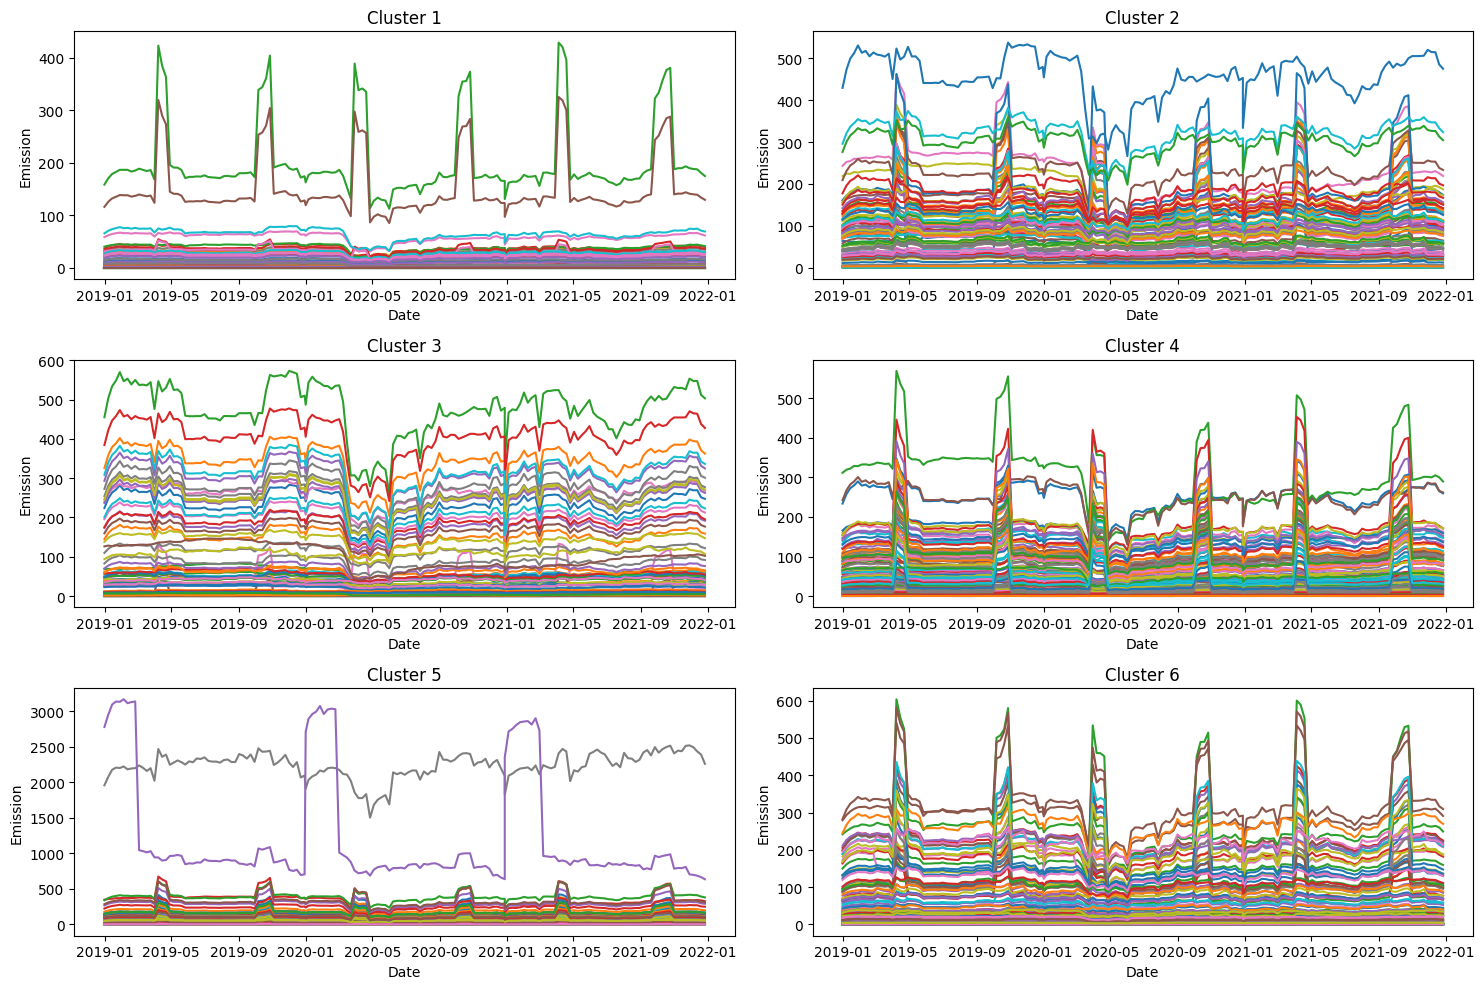

In [ ]:
# As can be seen the time series for the different locations in the many clusters have very similar time series graph patterns this suggests a linear dependance between measurements from different locations
# The plots show that the emission patterns across different clusters are quite similar. Peaks and troughs in emissions occur at the same time points across multiple locations.

# Another thing to observe is the sudden drop in emmisions at around month 5 of 2020 and how that corresponsds to the peak of covid times
plot_df=df[[ 'ds','latitude', 'longitude','emission']]
plot_df=plot_df.merge(Locations, on=['latitude', 'longitude'], how='left')

fig, axs = plt.subplots(3, 2, figsize=(15, 10))
axs = axs.flatten()
for cluster in range(6):
    cluster_data = plot_df[plot_df['cluster'] == cluster]
    for (lat, lon), group in cluster_data.groupby(['latitude', 'longitude']):
        axs[cluster].plot(group['ds'], group['emission'])

    axs[cluster].set_title(f'Cluster {cluster + 1}')

    axs[cluster].set_xlabel('Date')
    axs[cluster].set_ylabel('Emission')

plt.tight_layout()
plt.show()

### **As can be seen the time series for the different locations in the many clusters have very similar time series graph patterns this suggests a linear dependance between measurements from different locations**

### **The plots show that the emission patterns across different clusters are quite similar. Peaks and troughs in emissions occur at the same time points across multiple locations.**

### **Another thing to observe is the sudden drop in emmisions at around month 5 of 2020 and how that corresponsds to the peak of covid times**

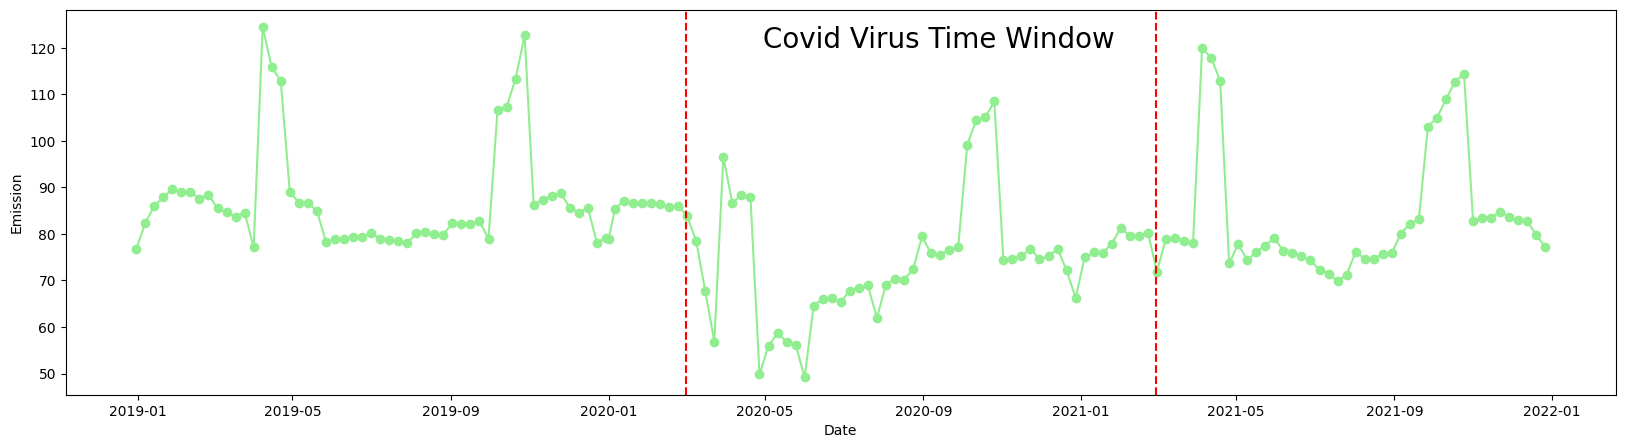

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming plot_df is your DataFrame
# Ensure 'ds' column is in datetime format
plot_df['ds'] = pd.to_datetime(plot_df['ds'])
# Create a figure and axis with a specified size
fig, ax = plt.subplots(figsize=(20, 5))

# Plot the mean emission values over time
ax.plot(plot_df.groupby(['ds'])['emission'].mean(), linestyle='-', marker='o',color='lightgreen')

# Add vertical lines to mark specific dates
plt.axvline(pd.Timestamp('2020-03-01'), linestyle = "--", color='red')
plt.axvline(pd.Timestamp('2021-02-28'), linestyle = "--", color='red')
# Add text annotation for the COVID-19 time window
plt.text(pd.Timestamp ('2020-04-30'), 120, "Covid Virus Time Window", size = 20)
# Set labels for x-axis and y-axis
ax.set_xlabel('Date')
ax.set_ylabel('Emission')

plt.show()


In [ ]:
plot_df.head()

ds  latitude  longitude  emission  cluster
0 2018-12-31     -0.51      29.29  3.750994        5
1 2019-01-07     -0.51      29.29  4.025176        5
2 2019-01-14     -0.51      29.29  4.231381        5
3 2019-01-21     -0.51      29.29  4.305286        5
4 2019-01-28     -0.51      29.29  4.347317        5

##Convert Covid Outliers to range of Non-COVID affected period


In [ ]:
import pandas as pd
# Assuming full_df is your DataFrame with columns 'ds', 'emission', 'latitude', 'longitude', 'week_no', 'year'
full_df = df[['ds', 'emission', 'latitude', 'longitude','week_no','year']]
full_df['ds'] = pd.to_datetime(full_df['ds'])
# Split data into pre-COVID and COVID periods
full_df_no_covid = full_df[(full_df['ds'] < pd.to_datetime('2020-03-01')) | (full_df['ds'] > pd.to_datetime('2021-02-28'))]
full_df_covid = full_df[(full_df['ds'] >= pd.to_datetime('2020-03-01')) & (full_df['ds'] <= pd.to_datetime('2021-02-28'))]
# Calculate average emissions per week for pre-COVID and COVID periods
avg_emission_no_virus = full_df_no_covid.groupby(full_df_no_covid['ds'].dt.isocalendar().week)['emission'].mean()
avg_emission_virus = full_df_covid.groupby(full_df_covid['ds'].dt.isocalendar().week)['emission'].mean()


# Calculate ratio of average emissions between pre-COVID and COVID periods
ratio = avg_emission_no_virus / avg_emission_virus

# Map the ratio back to the COVID period data
full_df_covid['ratio'] = full_df_covid['ds'].dt.isocalendar().week.map(ratio)
full_df_covid['emission'] *= full_df_covid['ratio']
# Update original full_df with adjusted emissions for COVID period
for index in full_df_covid.index:
    full_df.loc[index, 'emission'] = full_df_covid.loc[index, 'emission']

# Display the first few rows of full_df_covid (optional)
full_df_covid.head()


ds  emission  latitude  longitude  week_no  year     ratio
62 2020-03-02  4.184091     -0.51      29.29        9  2020  0.981318
63 2020-03-09  4.265761     -0.51      29.29       10  2020  1.044345
64 2020-03-16  4.611872     -0.51      29.29       11  2020  1.199304
65 2020-03-23  5.059628     -0.51      29.29       12  2020  1.430291
66 2020-03-30  3.140535     -0.51      29.29       13  2020  1.020717

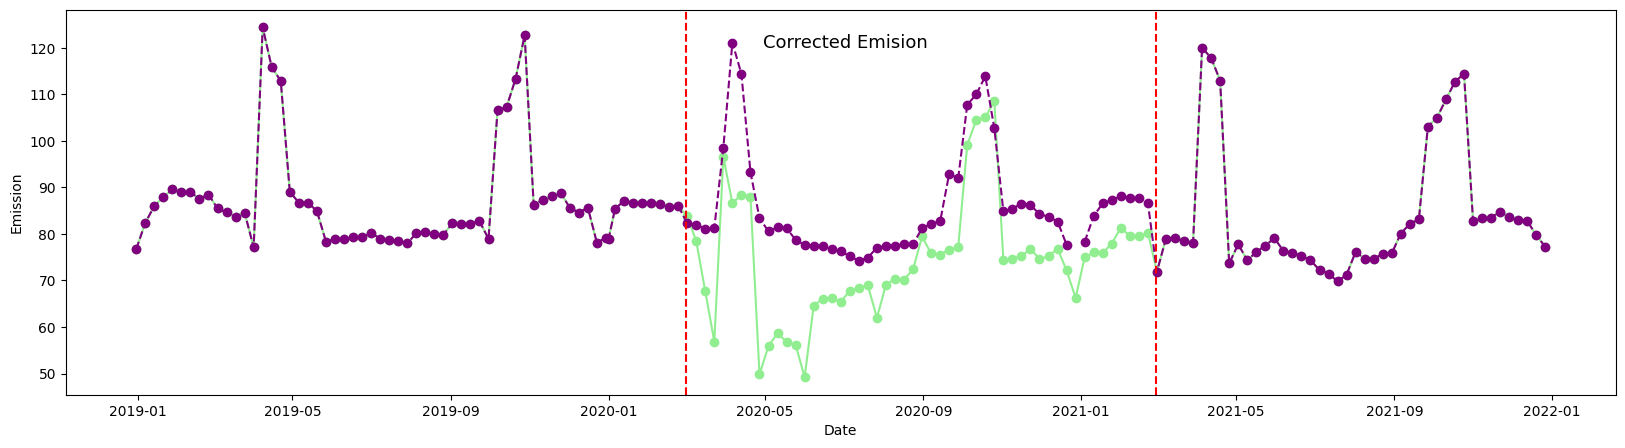

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


plot_df['ds'] = pd.to_datetime(plot_df['ds'])

fig, ax = plt.subplots(figsize=(20, 5))
# Plot mean emission values over time for plot_df and full_df
ax.plot(plot_df.groupby(['ds'])['emission'].mean(), linestyle='-', marker='o',color='lightgreen')
ax.plot(full_df.groupby(['ds'])['emission'].mean(), linestyle='--', marker='o',color='purple')
plt.axvline(pd.Timestamp('2020-03-01'), linestyle = "--", color='red')
plt.axvline(pd.Timestamp('2021-02-28'), linestyle = "--", color='red')
plt.text(pd.Timestamp ('2020-04-30'), 120, "Corrected Emision", size = 13)

ax.set_xlabel('Date')
ax.set_ylabel('Emission')

plt.show()


##MultiVariate Possibility


In [ ]:
data_corr=df.drop(columns=["ID_LAT_LON_YEAR_WEEK",'latitude',	'longitude',	'ds',	'year',	'week_no','emission'])
data_corr['emission']=full_df['emission']

def top_correlated_features(df, target, n=20):
    correlations = data_corr.corr()['emission'].drop(columns='emission')  # Calculate correlations and drop the target itself
    top_features = correlations.abs().nlargest(n+1)[1:]  # Get the top n features with highest absolute correlation

    return top_features

# Find the top 20 features most correlated with the target variable
top_20_features = top_correlated_features(data_corr, 'emission', 20)

# Display the top 20 correlated features
print("Top 20 Correlated Features with Target:")
print(top_20_features)


Top 20 Correlated Features with Target:
UvAerosolLayerHeight_aerosol_height                         0.069008
UvAerosolLayerHeight_aerosol_pressure                       0.068138
Cloud_surface_albedo                                        0.056037
CarbonMonoxide_CO_column_number_density                     0.046369
Formaldehyde_tropospheric_HCHO_column_number_density_amf    0.043322
UvAerosolLayerHeight_aerosol_optical_depth                  0.040156
CarbonMonoxide_H2O_column_number_density                    0.038842
Formaldehyde_tropospheric_HCHO_column_number_density        0.036124
UvAerosolLayerHeight_sensor_azimuth_angle                   0.035142
NitrogenDioxide_sensor_azimuth_angle                        0.029442
NitrogenDioxide_sensor_altitude                             0.028866
SulphurDioxide_sensor_azimuth_angle                         0.028799
UvAerosolLayerHeight_solar_azimuth_angle                    0.027214
NitrogenDioxide_solar_azimuth_angle                         0.0

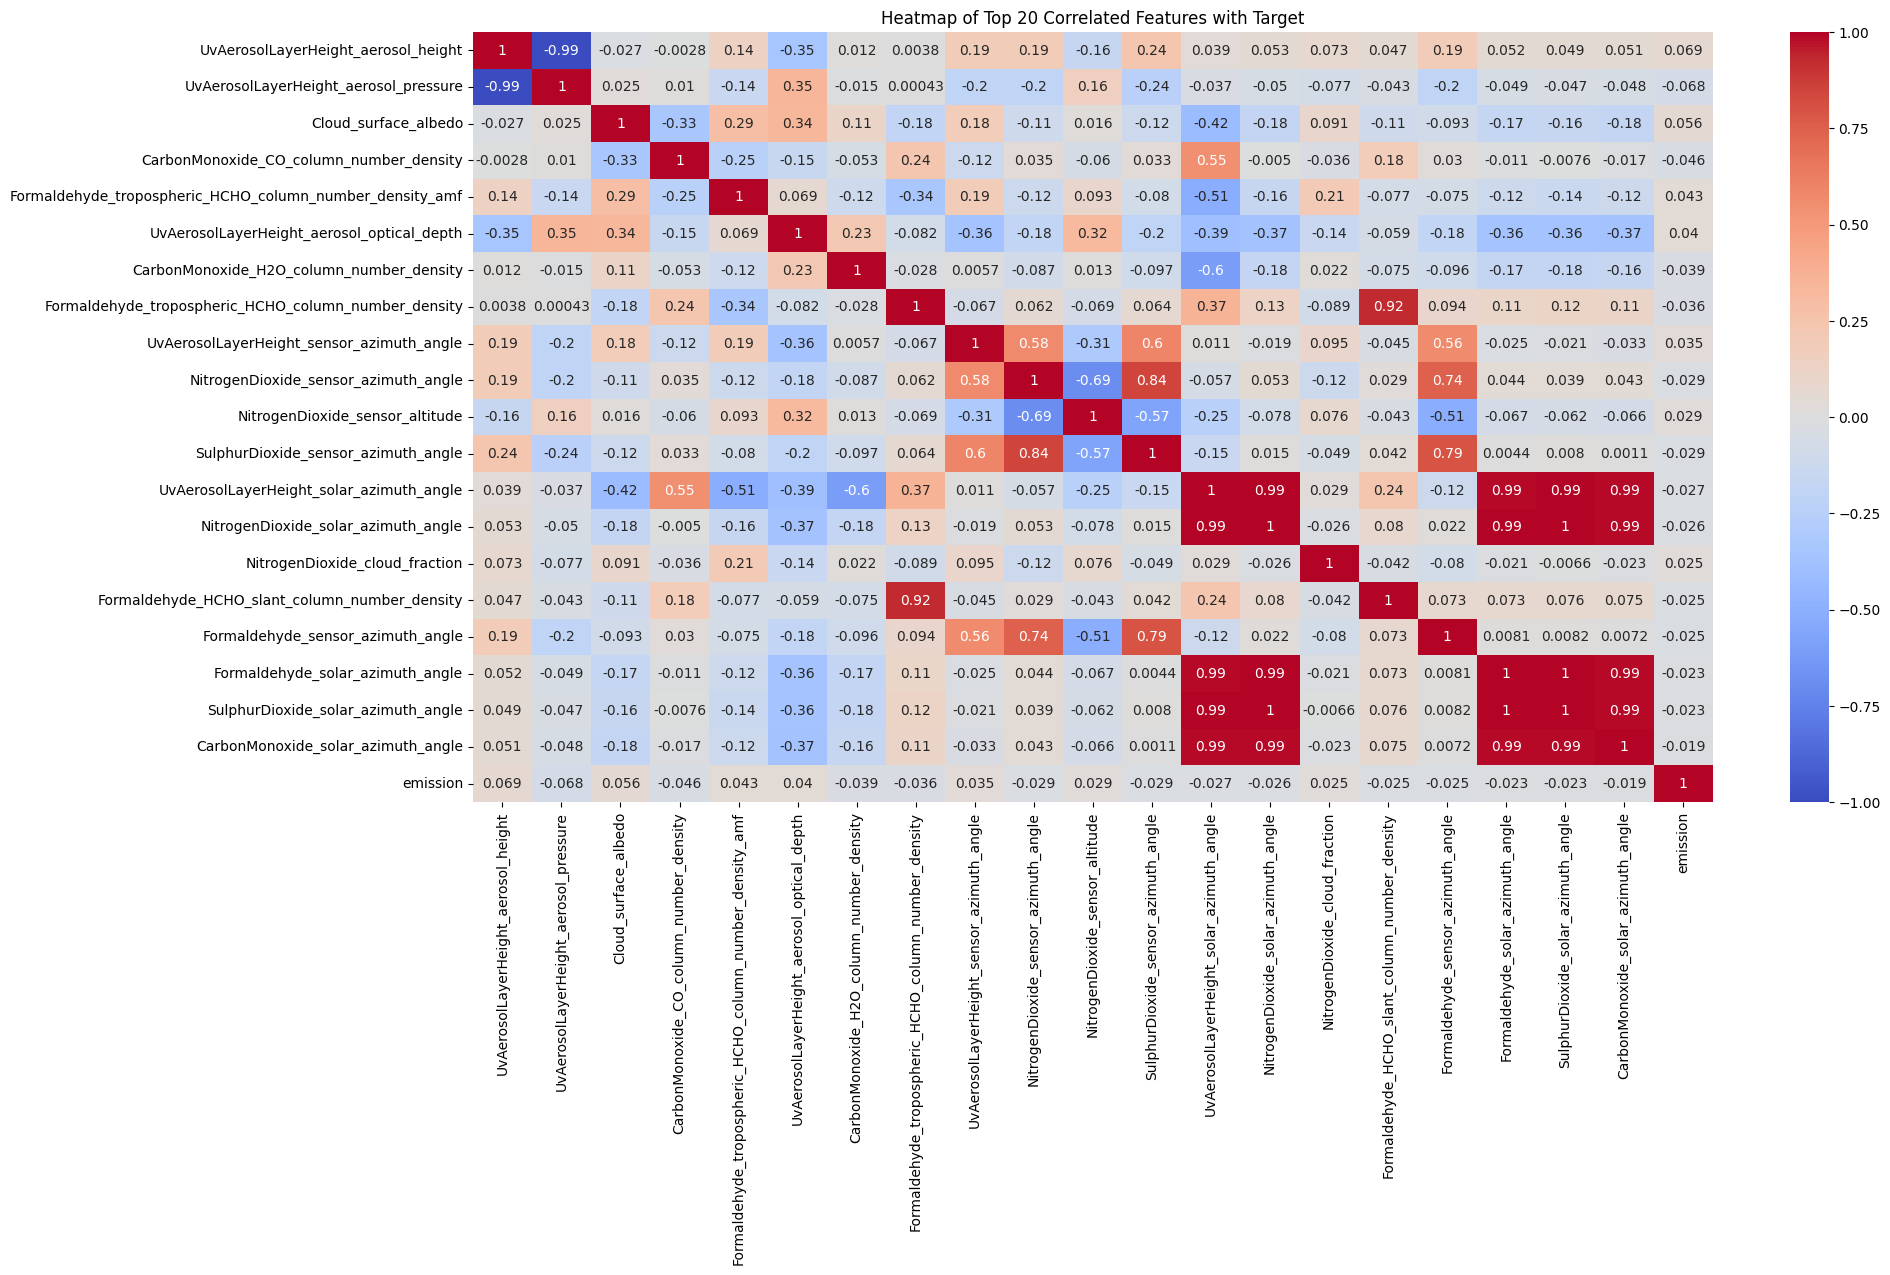

In [ ]:
# Plot heatmap of the top 20 correlated features with the target variable
def plot_top_correlated_heatmap(df, top_features, target):

    # Include the target variable in the list of top features
    top_features_list = top_features.index.tolist()
    top_features_list.append(target)

    # Filter the DataFrame to include only the top correlated features and the target
    df_top_corr = df[top_features_list]

    # Plot heatmap of correlations
    plt.figure(figsize=(20, 10))
    sns.heatmap(df_top_corr.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Heatmap of Top 20 Correlated Features with Target')
    plt.show()

# Plot the heatmap
plot_top_correlated_heatmap(data_corr, top_20_features, 'emission')

**1. Low Correlation with Target Variable. It indicates that none of these variables individually have a strong linear relationship with the target. This makes it challenging to use these variables for predictive modeling of the target variable using methods that rely on linear relationships, such as linear regression.**

**2. High Multicollinearity.Multicollinearity: High multicollinearity among variables means that these variables are highly correlated with each other. This can be problematic for many machine learning models because it can cause instability in the model coefficients and make it difficult to determine the individual effect of each variable.**

**3. Multivariate time series analysis typically requires strong relationships between the variables and the target variable, as well as manageable levels of multicollinearity. High multicollinearity and low correlation with the target variable suggest that these conditions are not met, reducing the feasibility of effective multivariate time series modeling with your current set of variables.**

#Dimensionality reduction


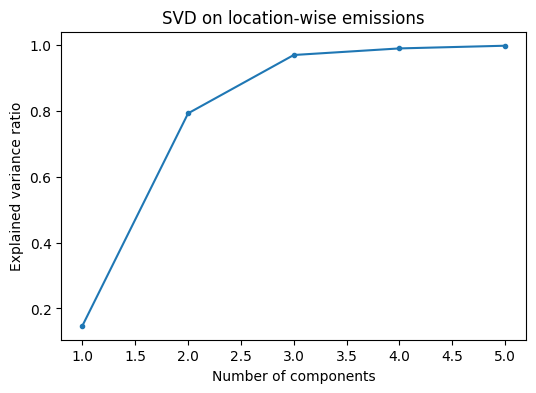

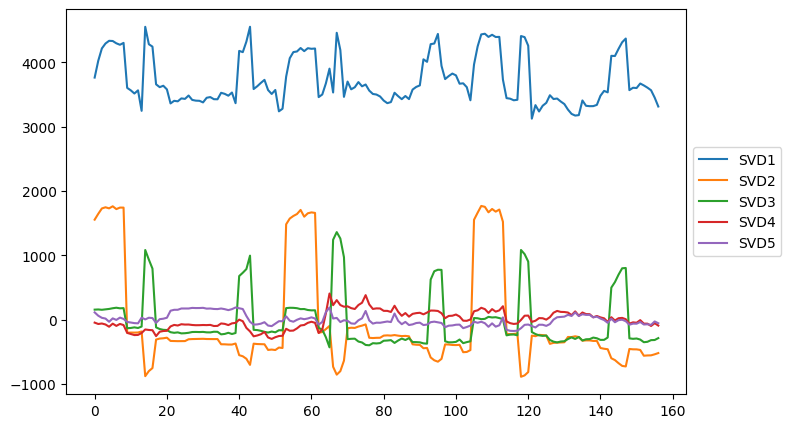

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

# Define useful columns
useful_columns = ['emission', 'week_no', 'year', 'latitude', 'longitude','ds']

# Filter data for useful columns
data_filtered = full_df[useful_columns]

# Pivot the data for latitude and longitude emissions over week_no and year
pivoted_data = data_filtered.pivot_table(index=['year', 'week_no'], columns=['latitude', 'longitude'], values='emission', aggfunc='mean')

# Define the number of components for SVD
n_components = 5

# Apply Truncated SVD
svd = TruncatedSVD(n_components=n_components)
svd.fit(pivoted_data)

# Plot cumulative explained variance ratio
fig, ax = plt.subplots(figsize=(6, 4), dpi=100)
ax.plot(1 + np.arange(n_components), svd.explained_variance_ratio_.cumsum(), marker='.')
ax.set_title('SVD on location-wise emissions')
ax.set_ylabel('Explained variance ratio')
ax.set_xlabel('Number of components')

# Fit and transform the data using SVD
top_components = svd.fit_transform(pivoted_data)
emission_pcs = svd.transform(pivoted_data)[:, :5]

# Plot the first 5 principal components
fig, ax = plt.subplots(figsize=(8, 5), dpi=100)
for i in range(emission_pcs.shape[1]):
    ax.plot(emission_pcs[:, i], label=f'SVD{i + 1}')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


In [ ]:

predicted_components_df=pd.DataFrame( columns=['ds']+[f'Component {i+1}' for i in range(n_components)])
predicted_components_df

Empty DataFrame
Columns: [ds, Component 1, Component 2, Component 3, Component 4, Component 5]
Index: []

In [ ]:
#emission_pcs[:, 0]

In [ ]:
pivoted_data['date'] = pivoted_data.index.to_series().apply(lambda x: pd.to_datetime(str(x[0]) +str(x[1]) + '1', format='%Y%W%w'))
components_df = pd.DataFrame(top_components, columns=[f'Component {i+1}' for i in range(n_components)])
components_df['ds'] = pivoted_data['date'].values

#pd.to_datetime(df['year'].astype(str) + df['week_no'].astype(str) + '1', format='%Y%W%w')

In [ ]:
components_df

Component 1  Component 2  Component 3  Component 4  Component 5  \
0    3764.715882  1556.179303   157.867479   -43.945432   115.388134   
1    4026.821349  1647.433099   160.661593   -65.143606    63.377128   
2    4218.243985  1730.586264   155.637836   -57.590867    30.642731   
3    4294.344449  1748.769519   162.342708   -72.914167    19.051967   
4    4336.289098  1732.014740   168.743164  -107.684066   -30.584170   
..           ...          ...          ...          ...          ...   
152  3642.677173  -558.281010  -348.333062   -59.671791   -73.121195   
153  3608.177097  -554.191817  -341.957324   -60.197524   -69.636475   
154  3567.501949  -552.454220  -316.063783   -95.831640   -78.822606   
155  3453.395720  -536.496198  -314.155705   -52.754716   -25.666435   
156  3315.187829  -517.140899  -284.783408   -89.596326   -53.619146   

            ds  
0   2018-12-31  
1   2019-01-07  
2   2019-01-14  
3   2019-01-21  
4   2019-01-28  
..         ...  
152 2021-11-29  
153 2021-12-06  
154 2021-12-13  
155 2021-12-20  
156 2021-12-27  

[157 rows x 6 columns]

#Component 1


##Arima

In [ ]:
df_nix=components_df[['Component 1','ds']]
df_nix['unique_id']=1
df_nix.columns= ['y','ds','unique_id']

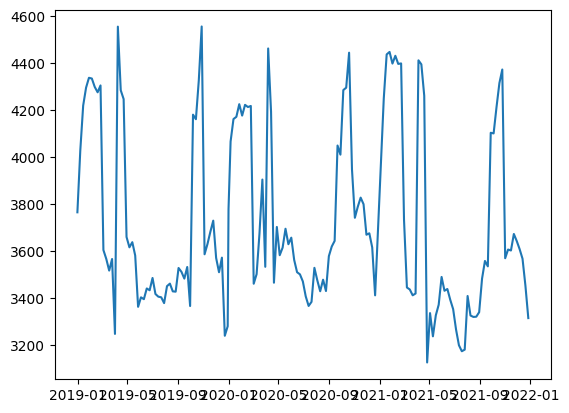

In [ ]:
plt.plot(df_nix['ds'],df_nix['y'])

In [ ]:
train_start = pd.to_datetime("2018-01-01")
train_end = pd.to_datetime("2021-9-16")
test_start = pd.to_datetime("2021-9-19")
test_end = pd.to_datetime("2022-01-01")

In [ ]:
train_df=df_nix[(df_nix["ds"] >= train_start) & (df_nix["ds"] <= train_end)]
test_df = df_nix[(df_nix["ds"] >= test_start) & (df_nix["ds"] <= test_end)]

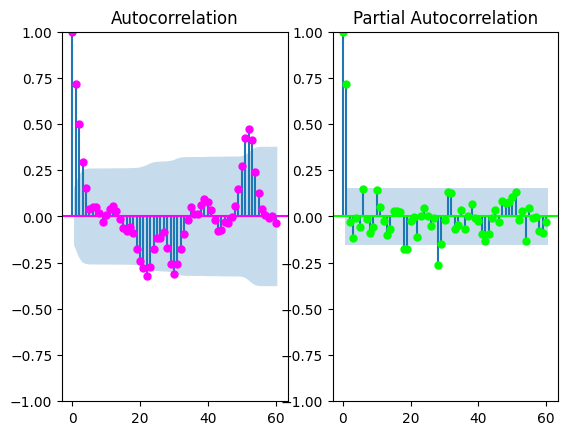

<Figure size 2000x2000 with 0 Axes>

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2)
plt.figure(figsize=(20,20))
plot_acf(df_nix["y"],  lags=60, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation");

plot_pacf(df_nix["y"],  lags=60, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

plt.show();

In [ ]:
models=[
    AutoARIMA(season_length=52)]
sf = StatsForecast(df=train_df,
                   models=models,
                   freq='W',
                   n_jobs=-1)

In [ ]:
sf.fit(train_df)

StatsForecast(models=[AutoARIMA])

In [ ]:
model_params = sf.fitted_[0][0].model_
# model_params


In [ ]:
model_params['loglik']#['loglik']#.coef.loglik

-618.8624249357352

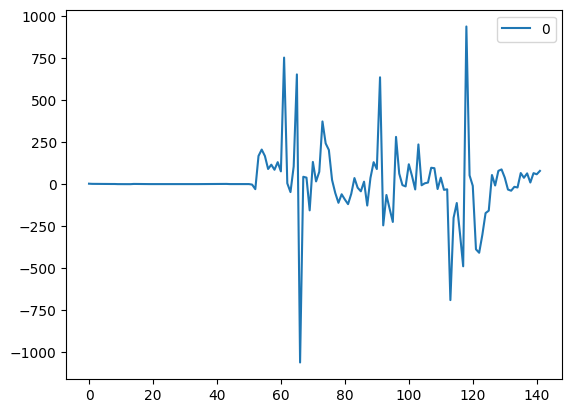

In [ ]:
residuals = pd.DataFrame(model_params["residuals"])
residuals.plot()
plt.show()

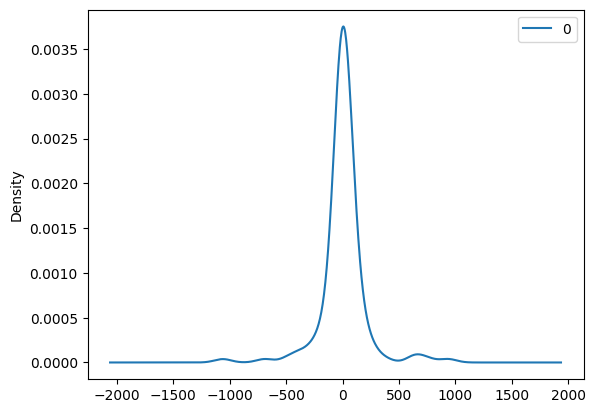

In [ ]:
residuals.plot(kind='kde')
plt.show()

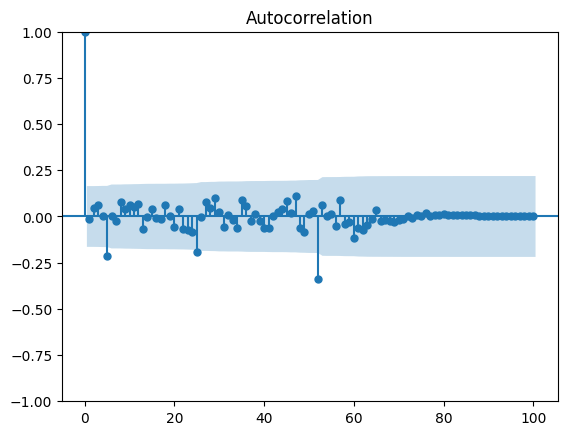

In [ ]:
plot_acf(residuals, lags=100)

plt.show()

In [ ]:
Y_hat = sf.forecast(h=test_df.shape[0],X_df=test_df.drop(['y'],axis=1).reset_index(drop=True),fitted=True)

In [ ]:
Y_hat.head()

ds    AutoARIMA
unique_id                        
1         2021-09-19  3514.398682
1         2021-09-26  3932.839355
1         2021-10-03  3891.494873
1         2021-10-10  4166.430176
1         2021-10-17  4176.562012

In [ ]:
test_df.head()

y         ds  unique_id
142  3535.045164 2021-09-20          1
143  4102.735779 2021-09-27          1
144  4099.967599 2021-10-04          1
145  4211.497266 2021-10-11          1
146  4313.818057 2021-10-18          1

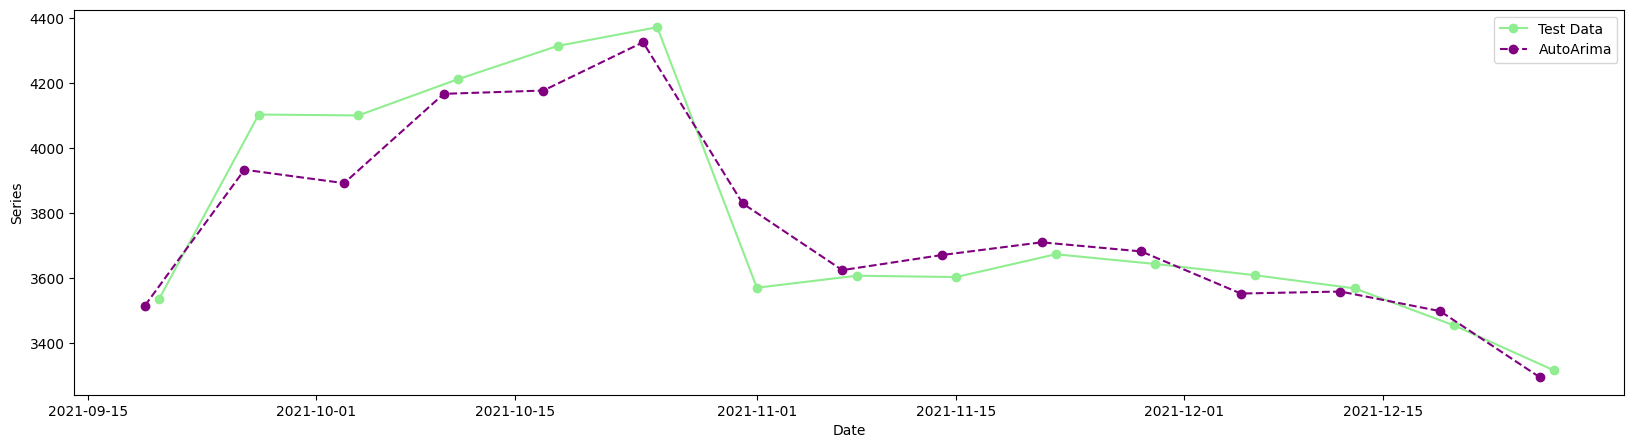

In [ ]:


fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(test_df['ds'], test_df['y'], linestyle='-', marker='o', color='lightgreen', label='Test Data')
ax.plot(Y_hat['ds'], Y_hat['AutoARIMA'], linestyle='--', marker='o', color='purple', label='AutoArima')

ax.set_xlabel('Date')
ax.set_ylabel('Series')

ax.legend()
plt.show()


In [ ]:
test_df.head()


y         ds  unique_id
142  3535.045164 2021-09-20          1
143  4102.735779 2021-09-27          1
144  4099.967599 2021-10-04          1
145  4211.497266 2021-10-11          1
146  4313.818057 2021-10-18          1

In [ ]:
Y_hat['ds']+= pd.Timedelta(days=1)
Y_hat.head()

ds    AutoARIMA
unique_id                        
1         2021-09-20  3514.398682
1         2021-09-27  3932.839355
1         2021-10-04  3891.494873
1         2021-10-11  4166.430176
1         2021-10-18  4176.562012

## Perform 10-fold cross-Validation by training a AutoArima model for each fold

In [ ]:
df_nix=components_df[['Component 1','ds']]
df_nix['unique_id']=1
df_nix.columns= ['y','ds','unique_id']
n_splits = 10
val_size = 14
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=val_size)

In [ ]:
for fold, (train_index, val_index) in enumerate(tscv.split(train_df)):
    print("Fold: {}".format(fold))
    print(f"TRAIN indices: {train_index.min()} to {train_index.max()} \n VALIDATION indices: {val_index.min()} to {val_index.max()}")
    print("\n")

In [ ]:
mape_ls = []
for fold, (train_index, val_index) in enumerate(tscv.split(train_df)):
  print(f"TRAIN indices: {train_index.min()} to {train_index.max()} \n VALIDATION indices: {val_index.min()} to {val_index.max()}")
  print("Fold: {}".format(fold))
  train_fold_df = train_df.iloc[train_index]
  val_fold_df = train_df.iloc[val_index]
  models = [ AutoARIMA(season_length=52)]
  sf = StatsForecast(df=train_fold_df,
                    models=models,
                    freq='W',
                    n_jobs=-1)
  sf.fit(train_fold_df)

  Y_hat=sf.forecast(h=val_size,X_df=val_fold_df.drop(['y'],axis=1).reset_index(drop=True),fitted=True)
  Y_hat['ds']+= pd.Timedelta(days=1)
  val_fold_df=val_fold_df.merge(Y_hat, on=['ds'], how='left')

  # if fold==2:
  #  break
  val_fold_df['AutoARIMA'].ffill(inplace=True)

  mape = np.round(100*mean_absolute_percentage_error(val_fold_df["y"],val_fold_df["AutoARIMA"]),2)
  mape_ls.append(mape)
  print(f"The validation MAPE is {mape}%")




TRAIN indices: 0 to 1 
 VALIDATION indices: 2 to 15
Fold: 0
The validation MAPE is 100.0%
TRAIN indices: 0 to 15 
 VALIDATION indices: 16 to 29
Fold: 1
The validation MAPE is 16.92%
TRAIN indices: 0 to 29 
 VALIDATION indices: 30 to 43
Fold: 2
The validation MAPE is 7.3%
TRAIN indices: 0 to 43 
 VALIDATION indices: 44 to 57
Fold: 3
The validation MAPE is 22.96%
TRAIN indices: 0 to 57 
 VALIDATION indices: 58 to 71
Fold: 4
The validation MAPE is 9.15%
TRAIN indices: 0 to 71 
 VALIDATION indices: 72 to 85
Fold: 5
The validation MAPE is 2.1%
TRAIN indices: 0 to 85 
 VALIDATION indices: 86 to 99
Fold: 6
The validation MAPE is 11.6%
TRAIN indices: 0 to 99 
 VALIDATION indices: 100 to 113
Fold: 7
The validation MAPE is 9.31%
TRAIN indices: 0 to 113 
 VALIDATION indices: 114 to 127
Fold: 8
The validation MAPE is 9.83%
TRAIN indices: 0 to 127 
 VALIDATION indices: 128 to 141
Fold: 9
The validation MAPE is 4.27%


In [ ]:
Y_hat.head()

ds    AutoARIMA
unique_id                        
1         2019-07-29  3403.687744
1         2019-08-05  3403.687744
1         2019-08-12  3403.687744
1         2019-08-19  3403.687744
1         2019-08-26  3403.687744

In [ ]:
val_fold_df

y         ds  unique_id    AutoARIMA
0   3586.429443 2019-11-04          1  4554.349609
1   3629.736912 2019-11-11          1  4554.349609
2   3681.915939 2019-11-18          1  4554.349609
3   3729.200338 2019-11-25          1  4554.349609
4   3570.799049 2019-12-02          1  4554.349609
5   3510.053323 2019-12-09          1  4554.349609
6   3572.071709 2019-12-16          1  4554.349609
7   3240.200421 2019-12-23          1  4554.349609
8   3280.610974 2019-12-30          1  4554.349609
9   3778.488859 2020-01-01          1          NaN
10  4065.367811 2020-01-06          1  4554.349609
11  4160.974186 2020-01-13          1  4554.349609
12  4170.516999 2020-01-20          1  4554.349609
13  4224.203254 2020-01-27          1  4554.349609

##prophet

In [ ]:
df_nix=components_df[['Component 1','ds']]

df_nix.columns= ['y','ds']
train_start = pd.to_datetime("2018-01-01")
train_end = pd.to_datetime("2021-9-16")
test_start = pd.to_datetime("2021-9-19")
test_end = pd.to_datetime("2022-01-01")
train_df=df_nix[(df_nix["ds"] >= train_start) & (df_nix["ds"] <= train_end)]
test_df = df_nix[(df_nix["ds"] >= test_start) & (df_nix["ds"] <= test_end)]

In [ ]:
prophet_model = Prophet(#growth='linear',
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=True,
    seasonality_mode='additive').fit(train_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_y0_dpbj/8ejhym7j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_y0_dpbj/g6st030o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41035', 'data', 'file=/tmp/tmp_y0_dpbj/8ejhym7j.json', 'init=/tmp/tmp_y0_dpbj/g6st030o.json', 'output', 'file=/tmp/tmp_y0_dpbj/prophet_modelmrlvuja6/prophet_model-20240620230538.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:05:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:05:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
test_df.shape[0]

15

In [ ]:
future = prophet_model.make_future_dataframe(periods=test_df.shape[0], freq="w")
prophet_forecast_uni = prophet_model.predict(future)


In [ ]:
prophet_forecast_uni[['ds', 'yhat']]

ds         yhat
0   2018-12-31  3684.419704
1   2019-01-07  4000.474691
2   2019-01-14  4237.648989
3   2019-01-21  4330.700032
4   2019-01-28  4328.308094
..         ...          ...
152 2021-11-28  3619.863917
153 2021-12-05  3515.439541
154 2021-12-12  3334.471130
155 2021-12-19  3242.393049
156 2021-12-26  3354.198444

[157 rows x 2 columns]

In [ ]:
to_plot=prophet_forecast_uni[['ds', 'yhat']]
to_plot=to_plot[(to_plot["ds"] >= test_start )& (to_plot["ds"] <= test_end)]
to_plot['ds']+=pd.Timedelta(days=1)

In [ ]:
predicted_components_df['Component 1']=to_plot['yhat']

In [ ]:
to_plot['ds']

142   2021-09-20
143   2021-09-27
144   2021-10-04
145   2021-10-11
146   2021-10-18
147   2021-10-25
148   2021-11-01
149   2021-11-08
150   2021-11-15
151   2021-11-22
152   2021-11-29
153   2021-12-06
154   2021-12-13
155   2021-12-20
156   2021-12-27
Name: ds, dtype: datetime64[ns]

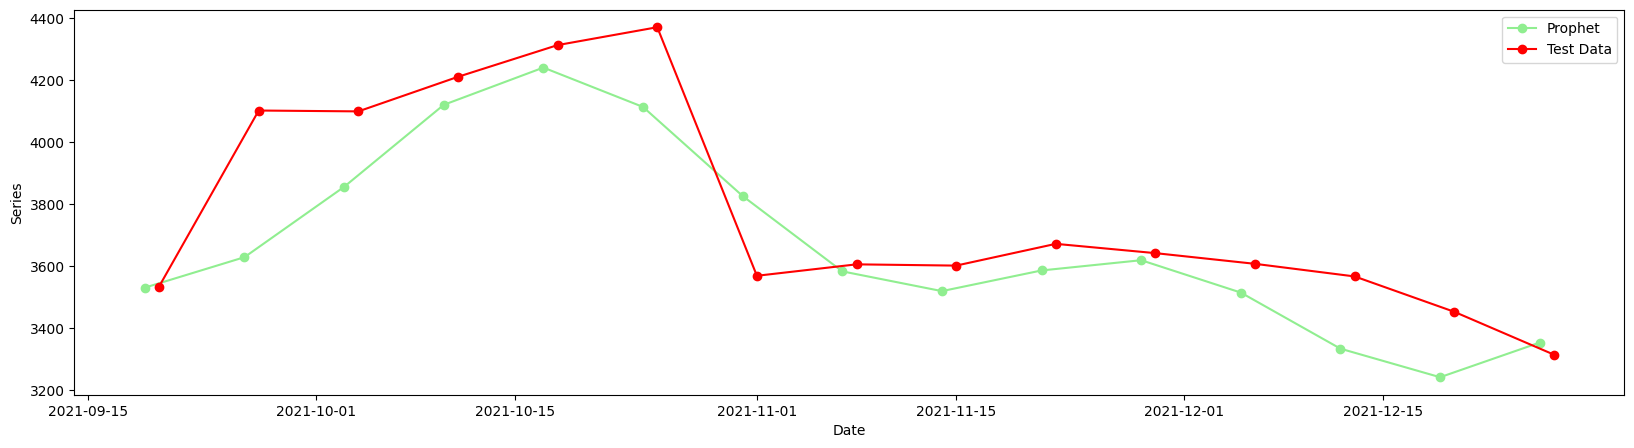

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(to_plot['ds'], to_plot['yhat'], linestyle='-', marker='o', color='lightgreen', label='Prophet')
ax.plot(test_df['ds'], test_df['y'], linestyle='-', marker='o', color='Red', label='Test Data')

ax.set_xlabel('Date')
ax.set_ylabel('Series')

ax.legend()
plt.show()


##Time Series Cross Validation for prophet

In [ ]:
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
df_nix=components_df[['Component 1','ds']]
df_nix['unique_id']=1
df_nix.columns= ['y','ds','unique_id']
prophet_df=df_nix[['ds','y']]
prophet_df.columns=['ds','y']
prophet_df['ds']=pd.to_datetime(prophet_df['ds'])
df = prophet_df
total_length = len(df)
window_size = total_length // 10
results = {}
for component in df.columns[1:]:
    component_df = df[['ds', component]].rename(columns={'Date': 'ds', component: 'y'})


    model = Prophet(#growth='linear',
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=True,
    seasonality_mode='additive')
    model.fit(component_df)


    df_cv =  cross_validation(model, initial=f'364 days', horizon='364 days')


    df_p = performance_metrics(df_cv)


    results[component] = df_p


for component, metrics in results.items():
    print(f"Results for component: {component}")
    metrics.drop('mse',axis=1,inplace=True)
    print(metrics)
    print("\n")



DEBUG:cmdstanpy:input tempfile: /tmp/tmp_y0_dpbj/e509us7n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_y0_dpbj/5ajb5e_s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70839', 'data', 'file=/tmp/tmp_y0_dpbj/e509us7n.json', 'init=/tmp/tmp_y0_dpbj/5ajb5e_s.json', 'output', 'file=/tmp/tmp_y0_dpbj/prophet_modelakw7mt4b/prophet_model-20240620230207.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:02:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:02:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2019-12-30 00:00:00 and 2020-12-28 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_y0_dpbj/oczidpe_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_y0_dpbj/f69i423m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80800', 'data', 'file=/tmp/tmp_y0_dpbj/oczidpe_.json', 'init=/tmp/tmp_y0_dpbj/f69i423m.json', 'output', 'file=/tmp/tmp_y0_dpbj/prophet_modelmp7ehwnq/prophet_model-20240620230208.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:02:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:02:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_y0_dpbj/fvraxh3f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_y0_dpbj/mf3ce4vu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

Results for component: y
    horizon        rmse         mae      mape     mdape     smape  coverage
0   35 days  264.860950  182.556612  0.044435  0.022511  0.046617  0.666667
1   42 days  237.766071  171.073603  0.041205  0.022511  0.042907  0.666667
2   49 days  228.152562  171.215772  0.041343  0.023629  0.042899  0.666667
3   56 days  252.685596  186.206422  0.044717  0.024811  0.046621  0.666667
4   63 days  239.283012  169.689887  0.041316  0.024811  0.042797  0.666667
5   70 days  253.350080  189.486460  0.048200  0.025143  0.049783  0.600000
6   77 days  314.923094  228.472828  0.060113  0.040605  0.063240  0.600000
7   84 days  429.522264  314.117287  0.082632  0.060342  0.088727  0.533333
8   91 days  449.345704  352.032581  0.094869  0.066273  0.100530  0.400000
9   98 days  511.577960  429.720300  0.111486  0.104103  0.119028  0.266667
10 105 days  507.129303  418.021793  0.106352  0.092298  0.113859  0.333333
11 112 days  465.685796  374.356659  0.094244  0.085155  0.0997

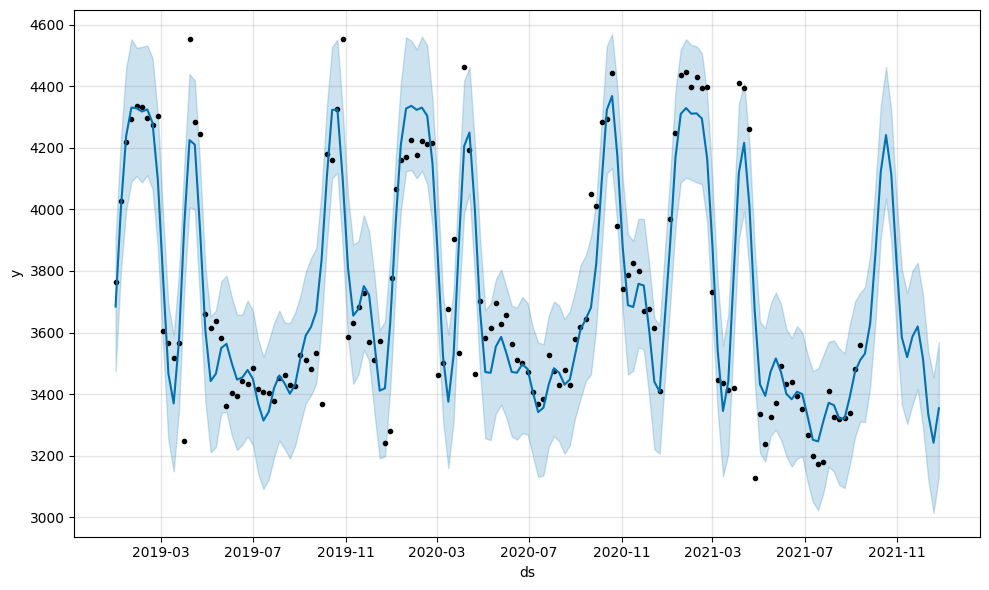

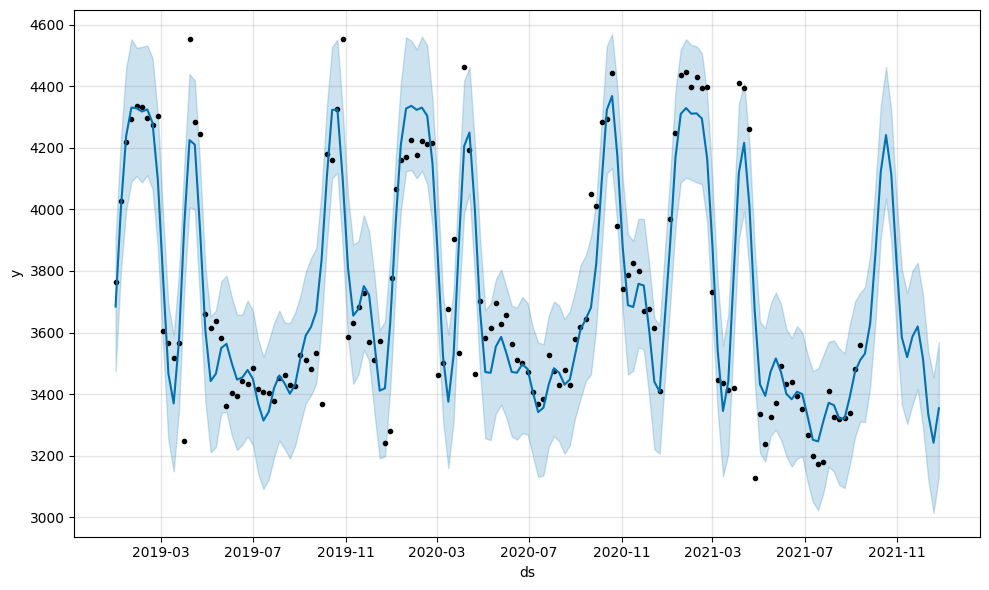

In [ ]:
prophet_model.plot(prophet_forecast_uni)

#Component 2


##Arima

In [ ]:
df_nix=components_df[['Component 2','ds']]
df_nix['unique_id']=1
df_nix.columns= ['y','ds','unique_id']

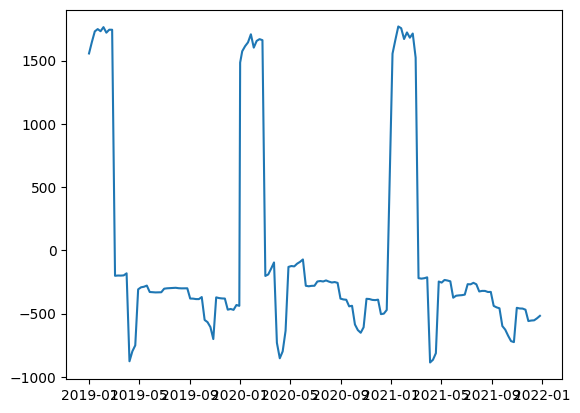

In [ ]:
plt.plot(df_nix['ds'],df_nix['y'])

In [ ]:
train_start = pd.to_datetime("2018-01-01")
train_end = pd.to_datetime("2021-9-16")
test_start = pd.to_datetime("2021-9-19")
test_end = pd.to_datetime("2022-01-01")

In [ ]:
train_df=df_nix[(df_nix["ds"] >= train_start) & (df_nix["ds"] <= train_end)]
test_df = df_nix[(df_nix["ds"] >= test_start) & (df_nix["ds"] <= test_end)]

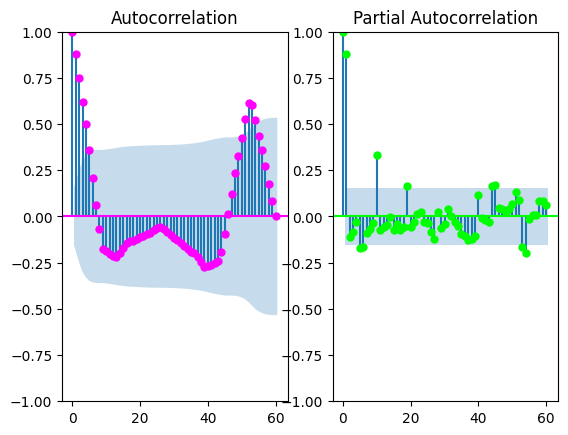

<Figure size 2000x2000 with 0 Axes>

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2)
plt.figure(figsize=(20,20))
plot_acf(df_nix["y"],  lags=60, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation");

plot_pacf(df_nix["y"],  lags=60, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

plt.show();

In [ ]:
models=[
    AutoARIMA(season_length=52)]
sf = StatsForecast(df=train_df,
                   models=models,
                   freq='W',
                   n_jobs=-1)

In [ ]:
sf.fit(train_df)

StatsForecast(models=[AutoARIMA])

In [ ]:
model_params = sf.fitted_[0][0].model_
# model_params


In [ ]:
model_params['loglik']#['loglik']#.coef.loglik

-643.9601599248365

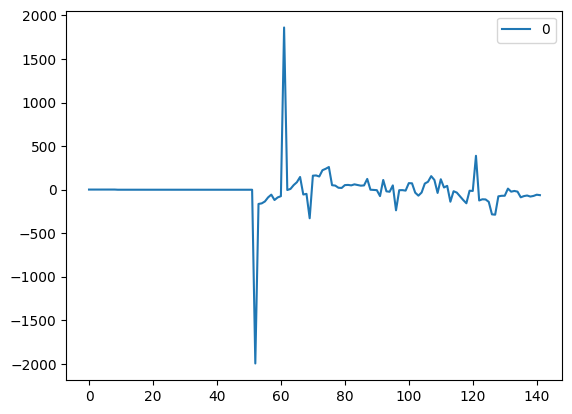

In [ ]:
residuals = pd.DataFrame(model_params["residuals"])
residuals.plot()
plt.show()

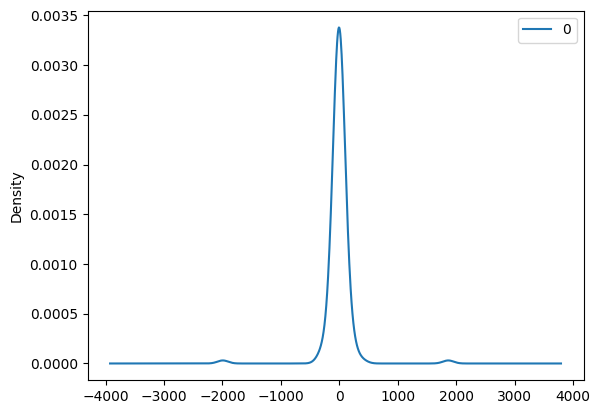

In [ ]:
residuals.plot(kind='kde')
plt.show()

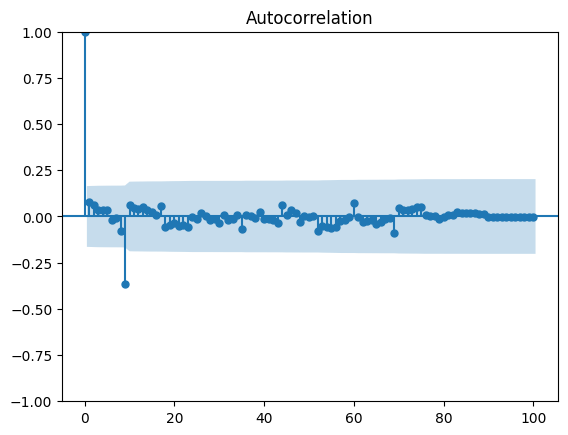

In [ ]:
plot_acf(residuals, lags=100)

plt.show()

In [ ]:
Y_hat = sf.forecast(h=test_df.shape[0],X_df=test_df.drop(['y'],axis=1).reset_index(drop=True),fitted=True)
Y_hat['ds']+= pd.Timedelta(days=1)

In [ ]:
Y_hat.head()

ds   AutoARIMA
unique_id                       
1         2021-09-20 -390.049683
1         2021-09-27 -442.064484
1         2021-10-04 -437.762329
1         2021-10-11 -585.444397
1         2021-10-18 -629.621887

In [ ]:
test_df.head()

y         ds  unique_id
142 -457.537670 2021-09-20          1
143 -597.878894 2021-09-27          1
144 -626.388411 2021-10-04          1
145 -674.386640 2021-10-11          1
146 -716.648623 2021-10-18          1

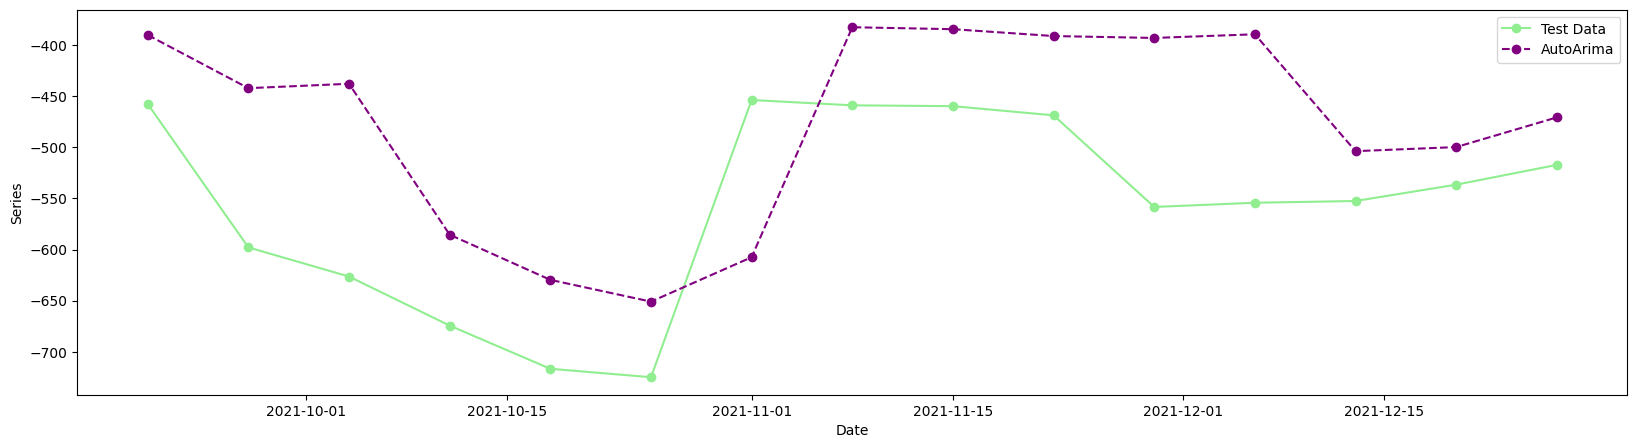

In [ ]:


fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(test_df['ds'], test_df['y'], linestyle='-', marker='o', color='lightgreen', label='Test Data')
ax.plot(Y_hat['ds'], Y_hat['AutoARIMA'], linestyle='--', marker='o', color='purple', label='AutoArima')

ax.set_xlabel('Date')
ax.set_ylabel('Series')

ax.legend()
plt.show()


In [ ]:
test_df.head()


y         ds  unique_id
142 -457.537670 2021-09-20          1
143 -597.878894 2021-09-27          1
144 -626.388411 2021-10-04          1
145 -674.386640 2021-10-11          1
146 -716.648623 2021-10-18          1

In [ ]:

Y_hat.head()

ds   AutoARIMA
unique_id                       
1         2021-09-20 -390.049683
1         2021-09-27 -442.064484
1         2021-10-04 -437.762329
1         2021-10-11 -585.444397
1         2021-10-18 -629.621887

## Perform 10-fold cross-Validation by training a AutoArima model for each fold

In [ ]:
df_nix=components_df[['Component 2','ds']]
df_nix['unique_id']=1
df_nix.columns= ['y','ds','unique_id']
n_splits = 10
val_size = 7
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=val_size)

In [ ]:
for fold, (train_index, val_index) in enumerate(tscv.split(train_df)):
    print("Fold: {}".format(fold))
    print(f"TRAIN indices: {train_index.min()} to {train_index.max()} \n VALIDATION indices: {val_index.min()} to {val_index.max()}")
    print("\n")

Fold: 0
TRAIN indices: 0 to 71 
 VALIDATION indices: 72 to 78


Fold: 1
TRAIN indices: 0 to 78 
 VALIDATION indices: 79 to 85


Fold: 2
TRAIN indices: 0 to 85 
 VALIDATION indices: 86 to 92


Fold: 3
TRAIN indices: 0 to 92 
 VALIDATION indices: 93 to 99


Fold: 4
TRAIN indices: 0 to 99 
 VALIDATION indices: 100 to 106


Fold: 5
TRAIN indices: 0 to 106 
 VALIDATION indices: 107 to 113


Fold: 6
TRAIN indices: 0 to 113 
 VALIDATION indices: 114 to 120


Fold: 7
TRAIN indices: 0 to 120 
 VALIDATION indices: 121 to 127


Fold: 8
TRAIN indices: 0 to 127 
 VALIDATION indices: 128 to 134


Fold: 9
TRAIN indices: 0 to 134 
 VALIDATION indices: 135 to 141




In [ ]:
mape_ls = []
for fold, (train_index, val_index) in enumerate(tscv.split(train_df)):
  print(f"TRAIN indices: {train_index.min()} to {train_index.max()} \n VALIDATION indices: {val_index.min()} to {val_index.max()}")
  print("Fold: {}".format(fold))
  train_fold_df = train_df.iloc[train_index]
  val_fold_df = train_df.iloc[val_index]
  models = [ AutoARIMA(season_length=52)]
  sf = StatsForecast(df=train_fold_df,
                    models=models,
                    freq='W',
                    n_jobs=-1)
  sf.fit(train_fold_df)

  Y_hat=sf.forecast(h=val_size,X_df=val_fold_df.drop(['y'],axis=1).reset_index(drop=True),fitted=True)
  Y_hat['ds']+= pd.Timedelta(days=1)
  val_fold_df=val_fold_df.merge(Y_hat, on=['ds'], how='left')

  # if fold==2:
  #  break
  val_fold_df['AutoARIMA'].ffill(inplace=True)

  mape = np.round(100*mean_absolute_percentage_error(val_fold_df["y"],val_fold_df["AutoARIMA"]),2)
  mape_ls.append(mape)
  print(f"The validation MAPE is {mape}%")




TRAIN indices: 0 to 71 
 VALIDATION indices: 72 to 78
Fold: 0
The validation MAPE is 86.61%
TRAIN indices: 0 to 78 
 VALIDATION indices: 79 to 85
Fold: 1
The validation MAPE is 24.95%
TRAIN indices: 0 to 85 
 VALIDATION indices: 86 to 92
Fold: 2
The validation MAPE is 69.82%
TRAIN indices: 0 to 92 
 VALIDATION indices: 93 to 99
Fold: 3
The validation MAPE is 103.55%
TRAIN indices: 0 to 99 
 VALIDATION indices: 100 to 106
Fold: 4
The validation MAPE is 55.67%
TRAIN indices: 0 to 106 
 VALIDATION indices: 107 to 113
Fold: 5
The validation MAPE is 5.36%
TRAIN indices: 0 to 113 
 VALIDATION indices: 114 to 120
Fold: 6
The validation MAPE is 19.0%
TRAIN indices: 0 to 120 
 VALIDATION indices: 121 to 127
Fold: 7
The validation MAPE is 73.38%
TRAIN indices: 0 to 127 
 VALIDATION indices: 128 to 134
Fold: 8
The validation MAPE is 12.56%
TRAIN indices: 0 to 134 
 VALIDATION indices: 135 to 141
Fold: 9
The validation MAPE is 20.46%


In [ ]:
Y_hat.head()

ds   AutoARIMA
unique_id                       
1         2021-08-02 -237.304565
1         2021-08-09 -246.655914
1         2021-08-16 -253.614792
1         2021-08-23 -250.097900
1         2021-08-30 -256.643646

In [ ]:
val_fold_df

y         ds  unique_id   AutoARIMA
0 -324.513341 2021-08-02          1 -237.304565
1 -319.951473 2021-08-09          1 -246.655914
2 -320.244924 2021-08-16          1 -253.614792
3 -328.642564 2021-08-23          1 -250.097900
4 -328.027779 2021-08-30          1 -256.643646
5 -438.482395 2021-09-06          1 -381.049408
6 -450.056288 2021-09-13          1 -387.579529

##prophet

In [ ]:
df_nix=components_df[['Component 2','ds']]

df_nix.columns= ['y','ds']
train_start = pd.to_datetime("2018-01-01")
train_end = pd.to_datetime("2021-9-16")
test_start = pd.to_datetime("2021-9-19")
test_end = pd.to_datetime("2022-01-01")
train_df=df_nix[(df_nix["ds"] >= train_start) & (df_nix["ds"] <= train_end)]
test_df = df_nix[(df_nix["ds"] >= test_start) & (df_nix["ds"] <= test_end)]

In [ ]:
prophet_model = Prophet(#growth='linear',
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=True,
    seasonality_mode='additive').fit(train_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_y0_dpbj/rlhupwzx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_y0_dpbj/rfmlqgkd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59063', 'data', 'file=/tmp/tmp_y0_dpbj/rlhupwzx.json', 'init=/tmp/tmp_y0_dpbj/rfmlqgkd.json', 'output', 'file=/tmp/tmp_y0_dpbj/prophet_model32eautzo/prophet_model-20240620231108.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:11:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:11:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
test_df.shape[0]

15

In [ ]:
future = prophet_model.make_future_dataframe(periods=test_df.shape[0], freq="w")
prophet_forecast_uni = prophet_model.predict(future)


In [ ]:
prophet_forecast_uni[['ds', 'yhat']]

ds         yhat
0   2018-12-31   840.681316
1   2019-01-07  1601.548260
2   2019-01-14  1873.578983
3   2019-01-21  1728.347342
4   2019-01-28  1575.668856
..         ...          ...
152 2021-11-28  -337.600819
153 2021-12-05  -499.723898
154 2021-12-12  -652.461448
155 2021-12-19  -467.981666
156 2021-12-26   203.116551

[157 rows x 2 columns]

In [ ]:
to_plot=prophet_forecast_uni[['ds', 'yhat']]
to_plot=to_plot[(to_plot["ds"] >= test_start )& (to_plot["ds"] <= test_end)]
to_plot['ds']+=pd.Timedelta(days=1)

In [ ]:
predicted_components_df['Component 2']=to_plot['yhat']

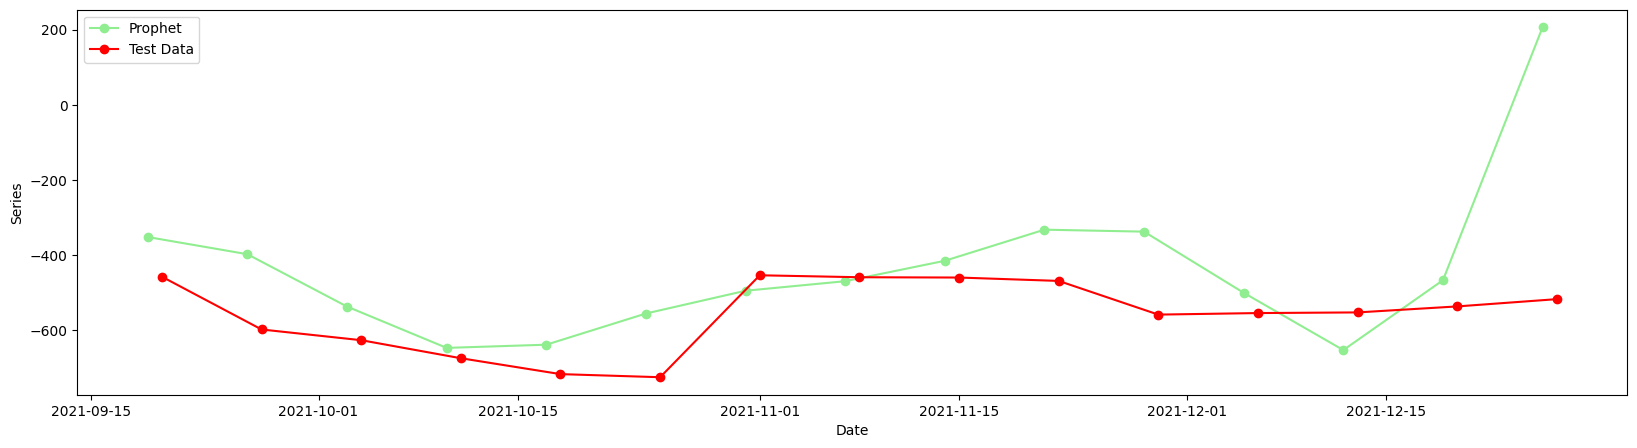

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(to_plot['ds'], to_plot['yhat'], linestyle='-', marker='o', color='lightgreen', label='Prophet')
ax.plot(test_df['ds'], test_df['y'], linestyle='-', marker='o', color='Red', label='Test Data')

ax.set_xlabel('Date')
ax.set_ylabel('Series')

ax.legend()
plt.show()


##Time Series Cross Validation for prophet

In [ ]:
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
df_nix=components_df[['Component 2','ds']]
df_nix['unique_id']=1
df_nix.columns= ['y','ds','unique_id']
prophet_df=df_nix[['ds','y']]
prophet_df.columns=['ds','y']
prophet_df['ds']=pd.to_datetime(prophet_df['ds'])
df = prophet_df
total_length = len(df)
window_size = total_length // 10
results = {}
for component in df.columns[1:]:
    component_df = df[['ds', component]].rename(columns={'Date': 'ds', component: 'y'})


    model = Prophet(#growth='linear',
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=True,
    seasonality_mode='additive')
    model.fit(component_df)


    df_cv =  cross_validation(model, initial=f'364 days', horizon='364 days')


    df_p = performance_metrics(df_cv)


    results[component] = df_p


for component, metrics in results.items():
    print(f"Results for component: {component}")
    metrics.drop('mse',axis=1,inplace=True)
    print(metrics)
    print("\n")



DEBUG:cmdstanpy:input tempfile: /tmp/tmp_y0_dpbj/9250e0c2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_y0_dpbj/u8camrml.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2329', 'data', 'file=/tmp/tmp_y0_dpbj/9250e0c2.json', 'init=/tmp/tmp_y0_dpbj/u8camrml.json', 'output', 'file=/tmp/tmp_y0_dpbj/prophet_modelg7hcr7s1/prophet_model-20240620231327.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:13:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:13:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2019-12-30 00:00:00 and 2020-12-28 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_y0_dpbj/j_8uy0go.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_y0_dpbj/b715wod5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38790', 'data', 'file=/tmp/tmp_y0_dpbj/j_8uy0go.json', 'init=/tmp/tmp_y0_dpbj/b715wod5.json', 'output', 'file=/tmp/tmp_y0_dpbj/prophet_model7s_20huu/prophet_model-20240620231327.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:13:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:13:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_y0_dpbj/hcsn844_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_y0_dpbj/ivrad4ep.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

Results for component: y
    horizon         rmse         mae      mape     mdape     smape  coverage
0   35 days  1041.020493  671.851605  0.514872  0.319309  0.789844  0.666667
1   42 days  1021.743944  651.768164  0.501155  0.319309  0.774456  0.666667
2   49 days  1019.746308  652.022081  0.499656  0.319309  0.776037  0.666667
3   56 days  1080.472672  705.556490  0.531641  0.338425  0.793623  0.600000
4   63 days  1038.250053  703.924676  0.850648  0.338425  0.796315  0.533333
5   70 days  1049.349401  706.067130  1.407470  0.338425  0.779593  0.533333
6   77 days  1100.436042  736.226971  2.307773  0.340285  0.789541  0.533333
7   84 days  1135.841485  761.900295  3.695453  0.413718  0.812464  0.533333
8   91 days  1037.129062  684.831706  3.751259  0.564703  0.746799  0.600000
9   98 days  1037.192688  650.567192  3.438261  0.413718  0.649428  0.666667
10 105 days  1046.156430  649.766580  2.930848  0.413718  0.577050  0.666667
11 112 days  1046.880587  643.445895  2.169086  0.2

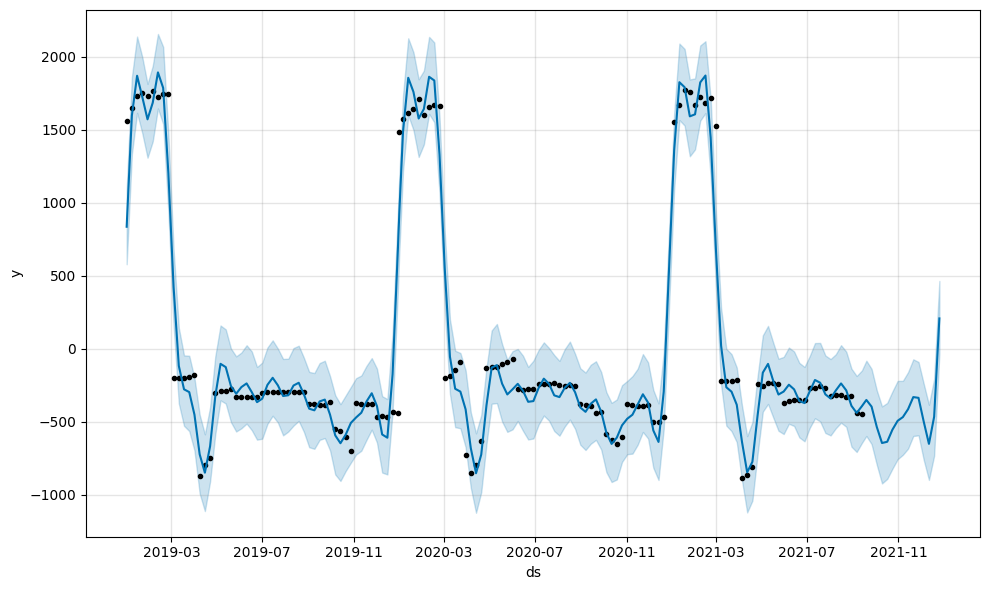

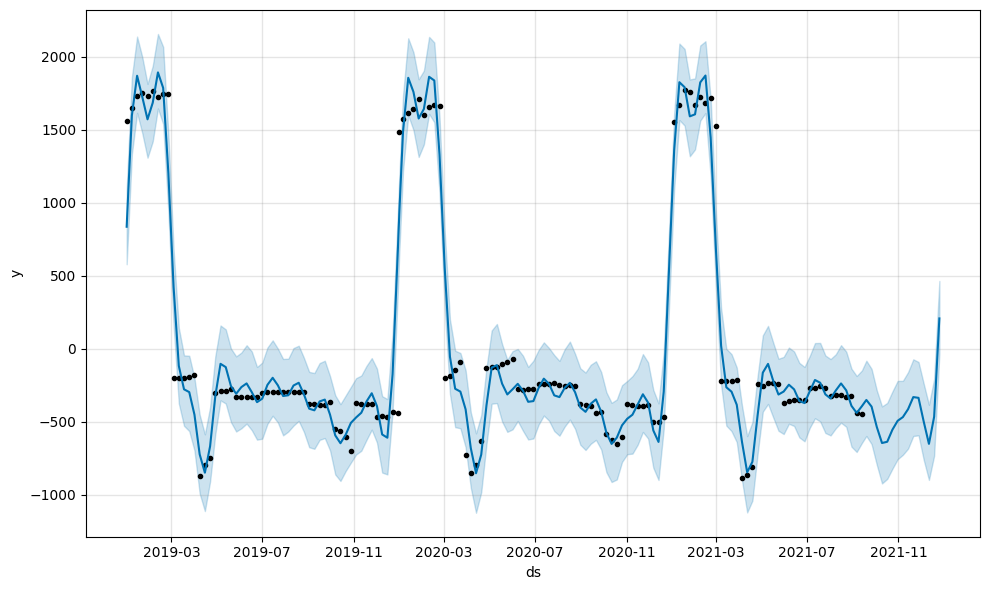

In [ ]:
prophet_model.plot(prophet_forecast_uni)

#Component 3


##Arima

In [ ]:
df_nix=components_df[['Component 3','ds']]
df_nix['unique_id']=1
df_nix.columns= ['y','ds','unique_id']

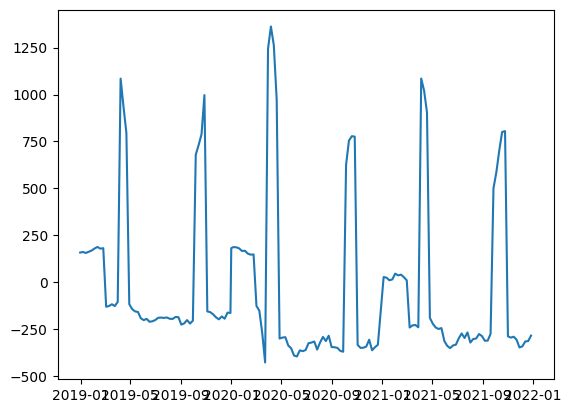

In [ ]:
plt.plot(df_nix['ds'],df_nix['y'])

In [ ]:
train_start = pd.to_datetime("2018-01-01")
train_end = pd.to_datetime("2021-9-16")
test_start = pd.to_datetime("2021-9-19")
test_end = pd.to_datetime("2022-01-01")

In [ ]:
train_df=df_nix[(df_nix["ds"] >= train_start) & (df_nix["ds"] <= train_end)]
test_df = df_nix[(df_nix["ds"] >= test_start) & (df_nix["ds"] <= test_end)]

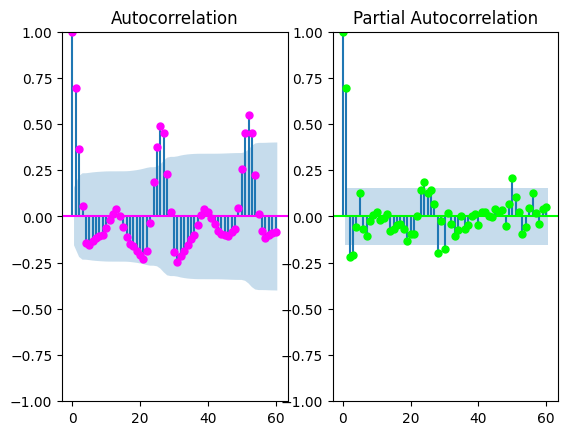

<Figure size 2000x2000 with 0 Axes>

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2)
plt.figure(figsize=(20,20))
plot_acf(df_nix["y"],  lags=60, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation");

plot_pacf(df_nix["y"],  lags=60, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

plt.show();

In [ ]:
models=[
    AutoARIMA(season_length=53)]
sf = StatsForecast(df=train_df,
                   models=models,
                   freq='W',
                   n_jobs=-1)

In [ ]:
sf.fit(train_df)

StatsForecast(models=[AutoARIMA])

In [ ]:
model_params = sf.fitted_[0][0].model_
# model_params


In [ ]:
model_params['loglik']#['loglik']#.coef.loglik

-630.0134073653949

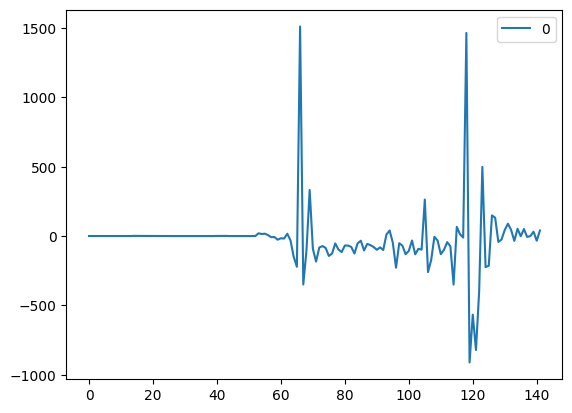

In [ ]:
residuals = pd.DataFrame(model_params["residuals"])
residuals.plot()
plt.show()

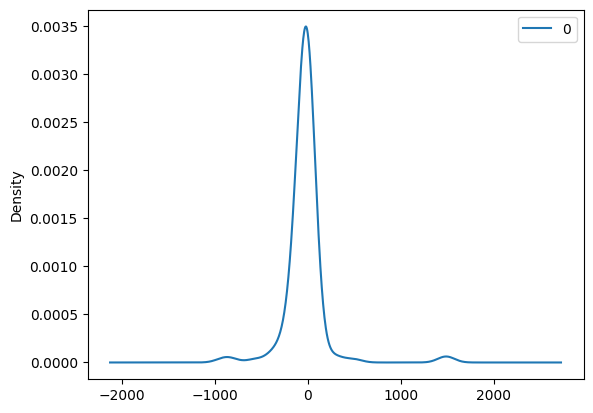

In [ ]:
residuals.plot(kind='kde')
plt.show()

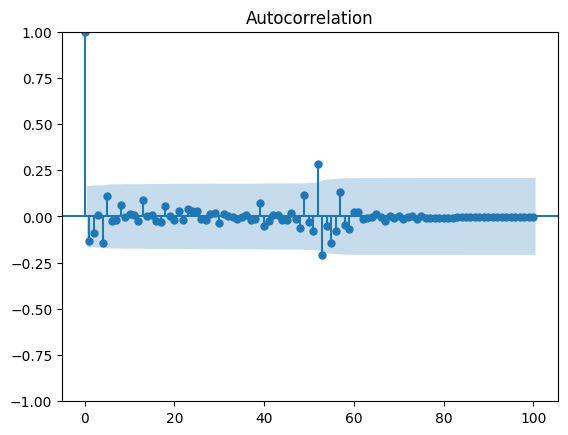

In [ ]:
plot_acf(residuals, lags=100)

plt.show()

In [ ]:
Y_hat = sf.forecast(h=test_df.shape[0],X_df=test_df.drop(['y'],axis=1).reset_index(drop=True),fitted=True)
Y_hat['ds']+= pd.Timedelta(days=1)

In [ ]:
Y_hat.head()

ds   AutoARIMA
unique_id                       
1         2021-09-20 -339.108154
1         2021-09-27 -337.925751
1         2021-10-04 -363.593750
1         2021-10-11 -374.532562
1         2021-10-18  622.507690

In [ ]:
test_df.head()

y         ds  unique_id
142 -275.602812 2021-09-20          1
143  500.301444 2021-09-27          1
144  586.160719 2021-10-04          1
145  701.752175 2021-10-11          1
146  800.528957 2021-10-18          1

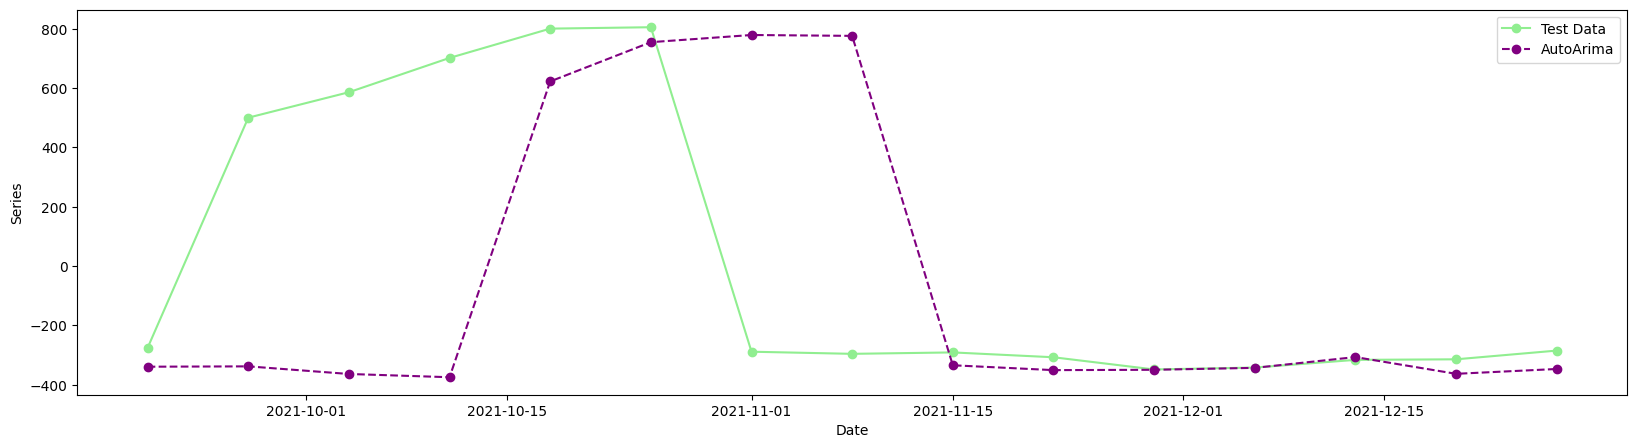

In [ ]:


fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(test_df['ds'], test_df['y'], linestyle='-', marker='o', color='lightgreen', label='Test Data')
ax.plot(Y_hat['ds'], Y_hat['AutoARIMA'], linestyle='--', marker='o', color='purple', label='AutoArima')

ax.set_xlabel('Date')
ax.set_ylabel('Series')

ax.legend()
plt.show()


In [ ]:
test_df.head()


y         ds  unique_id
142 -275.602812 2021-09-20          1
143  500.301444 2021-09-27          1
144  586.160719 2021-10-04          1
145  701.752175 2021-10-11          1
146  800.528957 2021-10-18          1

In [ ]:

Y_hat.head()

ds   AutoARIMA
unique_id                       
1         2021-09-20 -339.108154
1         2021-09-27 -337.925751
1         2021-10-04 -363.593750
1         2021-10-11 -374.532562
1         2021-10-18  622.507690

## Perform 10-fold cross-Validation by training a AutoArima model for each fold

In [ ]:
df_nix=components_df[['Component 3','ds']]
df_nix['unique_id']=1
df_nix.columns= ['y','ds','unique_id']
n_splits = 10
val_size = 14
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=val_size)

In [ ]:
for fold, (train_index, val_index) in enumerate(tscv.split(train_df)):
    print("Fold: {}".format(fold))
    print(f"TRAIN indices: {train_index.min()} to {train_index.max()} \n VALIDATION indices: {val_index.min()} to {val_index.max()}")
    print("\n")

Fold: 0
TRAIN indices: 0 to 1 
 VALIDATION indices: 2 to 15


Fold: 1
TRAIN indices: 0 to 15 
 VALIDATION indices: 16 to 29


Fold: 2
TRAIN indices: 0 to 29 
 VALIDATION indices: 30 to 43


Fold: 3
TRAIN indices: 0 to 43 
 VALIDATION indices: 44 to 57


Fold: 4
TRAIN indices: 0 to 57 
 VALIDATION indices: 58 to 71


Fold: 5
TRAIN indices: 0 to 71 
 VALIDATION indices: 72 to 85


Fold: 6
TRAIN indices: 0 to 85 
 VALIDATION indices: 86 to 99


Fold: 7
TRAIN indices: 0 to 99 
 VALIDATION indices: 100 to 113


Fold: 8
TRAIN indices: 0 to 113 
 VALIDATION indices: 114 to 127


Fold: 9
TRAIN indices: 0 to 127 
 VALIDATION indices: 128 to 141




In [ ]:
mape_ls = []
for fold, (train_index, val_index) in enumerate(tscv.split(train_df)):
  #print(f"TRAIN indices: {train_index.min()} to {train_index.max()} \n VALIDATION indices: {val_index.min()} to {val_index.max()}")
  print("Fold: {}".format(fold))
  train_fold_df = train_df.iloc[train_index]
  val_fold_df = train_df.iloc[val_index]
  models = [ AutoARIMA(season_length=53)]
  sf = StatsForecast(df=train_fold_df,
                    models=models,
                    freq='W',
                    n_jobs=-1)
  sf.fit(train_fold_df)

  Y_hat=sf.forecast(h=val_size,X_df=val_fold_df.drop(['y'],axis=1).reset_index(drop=True),fitted=True)
  Y_hat['ds']+= pd.Timedelta(days=1)
  val_fold_df=val_fold_df.merge(Y_hat, on=['ds'], how='left')

  # if fold==2:
  #  break
  val_fold_df['AutoARIMA'].ffill(inplace=True)

  mape = np.round(100*mean_absolute_percentage_error(val_fold_df["y"],val_fold_df["AutoARIMA"]),2)
  mape_ls.append(mape)
  print(f"The validation MAPE is {mape}%")




Fold: 0
The validation MAPE is 100.0%
Fold: 1
The validation MAPE is 168.06%
Fold: 2
The validation MAPE is 87.85%
Fold: 3
The validation MAPE is 216.75%
Fold: 4
The validation MAPE is 90.15%
Fold: 5
The validation MAPE is 89.88%
Fold: 6
The validation MAPE is 93.02%
Fold: 7
The validation MAPE is 94.27%
Fold: 8
The validation MAPE is 134.77%
Fold: 9
The validation MAPE is 12.95%


In [ ]:
Y_hat.head()

ds   AutoARIMA
unique_id                       
1         2021-06-14 -385.162354
1         2021-06-21 -393.194885
1         2021-06-28 -362.323761
1         2021-07-05 -367.088898
1         2021-07-12 -361.713501

In [ ]:
val_fold_df

y         ds  unique_id   AutoARIMA
0  -351.633054 2021-06-14          1 -385.162354
1  -337.492749 2021-06-21          1 -393.194885
2  -333.119741 2021-06-28          1 -362.323761
3  -299.092405 2021-07-05          1 -367.088898
4  -273.426871 2021-07-12          1 -361.713501
5  -297.694075 2021-07-19          1 -325.367004
6  -267.966898 2021-07-26          1 -322.083588
7  -321.977731 2021-08-02          1 -316.308807
8  -302.888076 2021-08-09          1 -359.371124
9  -300.556990 2021-08-16          1 -322.003937
10 -276.507959 2021-08-23          1 -291.849518
11 -287.161176 2021-08-30          1 -313.887421
12 -312.341299 2021-09-06          1 -285.476532
13 -311.620197 2021-09-13          1 -345.891510

##prophet

In [ ]:
df_nix=components_df[['Component 3','ds']]

df_nix.columns= ['y','ds']
train_start = pd.to_datetime("2018-01-01")
train_end = pd.to_datetime("2021-9-16")
test_start = pd.to_datetime("2021-9-19")
test_end = pd.to_datetime("2022-01-01")
train_df=df_nix[(df_nix["ds"] >= train_start) & (df_nix["ds"] <= train_end)]
test_df = df_nix[(df_nix["ds"] >= test_start) & (df_nix["ds"] <= test_end)]

In [ ]:
prophet_model = Prophet(#growth='linear',
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=True,
    seasonality_mode='additive').fit(train_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_y0_dpbj/pq38llyw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_y0_dpbj/4wrvnaoy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69893', 'data', 'file=/tmp/tmp_y0_dpbj/pq38llyw.json', 'init=/tmp/tmp_y0_dpbj/4wrvnaoy.json', 'output', 'file=/tmp/tmp_y0_dpbj/prophet_model3bf8qeld/prophet_model-20240620231356.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:13:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:13:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
test_df.shape[0]

15

In [ ]:
future = prophet_model.make_future_dataframe(periods=test_df.shape[0], freq="w")
prophet_forecast_uni = prophet_model.predict(future)


In [ ]:
prophet_forecast_uni[['ds', 'yhat']]

ds        yhat
0   2018-12-31   67.201759
1   2019-01-07  164.995244
2   2019-01-14  207.410013
3   2019-01-21  204.600434
4   2019-01-28  175.478367
..         ...         ...
152 2021-11-28 -330.568331
153 2021-12-05 -352.150866
154 2021-12-12 -372.680992
155 2021-12-19 -317.589263
156 2021-12-26 -193.718867

[157 rows x 2 columns]

In [ ]:
to_plot=prophet_forecast_uni[['ds', 'yhat']]
to_plot=to_plot[(to_plot["ds"] >= test_start )& (to_plot["ds"] <= test_end)]
to_plot['ds']+=pd.Timedelta(days=1)

In [ ]:
predicted_components_df['Component 3']=to_plot['yhat']

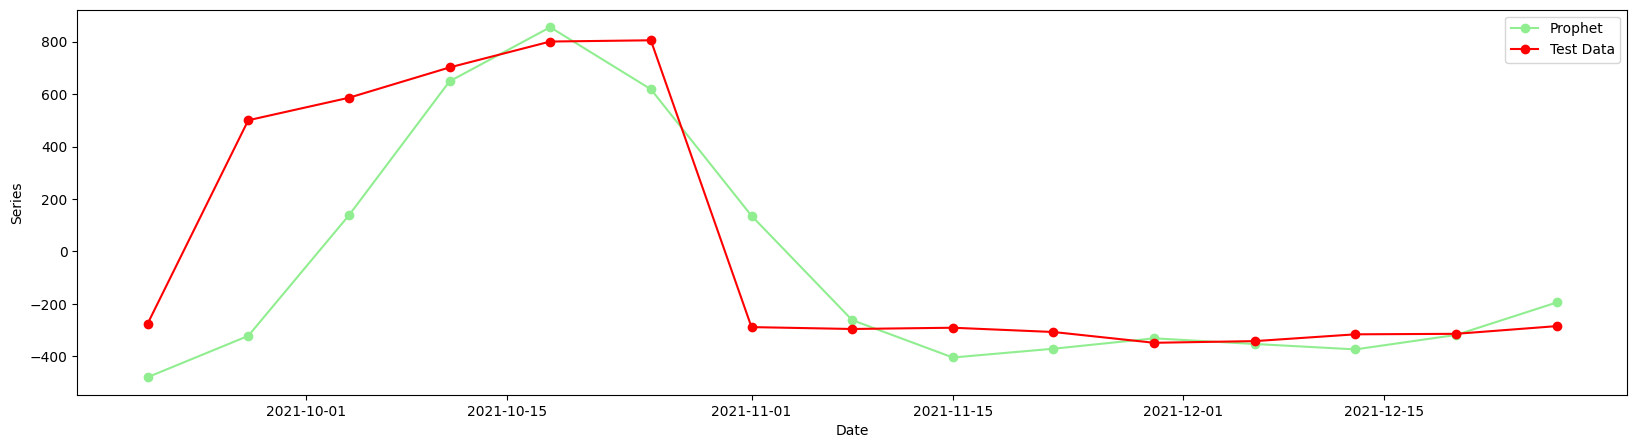

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(to_plot['ds'], to_plot['yhat'], linestyle='-', marker='o', color='lightgreen', label='Prophet')
ax.plot(test_df['ds'], test_df['y'], linestyle='-', marker='o', color='Red', label='Test Data')

ax.set_xlabel('Date')
ax.set_ylabel('Series')

ax.legend()
plt.show()


##Time Series Cross Validation for prophet

In [ ]:
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
df_nix=components_df[['Component 3','ds']]
df_nix['unique_id']=1
df_nix.columns= ['y','ds','unique_id']
prophet_df=df_nix[['ds','y']]
prophet_df.columns=['ds','y']
prophet_df['ds']=pd.to_datetime(prophet_df['ds'])
df = prophet_df
total_length = len(df)
window_size = total_length // 10
results = {}
for component in df.columns[1:]:
    component_df = df[['ds', component]].rename(columns={'Date': 'ds', component: 'y'})


    model = Prophet(#growth='linear',
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=True,
    seasonality_mode='additive')
    model.fit(component_df)


    df_cv =  cross_validation(model, initial=f'364 days', horizon='364 days')


    df_p = performance_metrics(df_cv)


    results[component] = df_p


for component, metrics in results.items():
    print(f"Results for component: {component}")
    metrics.drop('mse',axis=1,inplace=True)
    print(metrics)
    print("\n")



DEBUG:cmdstanpy:input tempfile: /tmp/tmp_y0_dpbj/etyouy_n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_y0_dpbj/64d55090.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47366', 'data', 'file=/tmp/tmp_y0_dpbj/etyouy_n.json', 'init=/tmp/tmp_y0_dpbj/64d55090.json', 'output', 'file=/tmp/tmp_y0_dpbj/prophet_model2apq2j8s/prophet_model-20240620231425.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:14:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:14:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2019-12-30 00:00:00 and 2020-12-28 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_y0_dpbj/hzezrfwb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_y0_dpbj/srfohqts.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69254', 'data', 'file=/tmp/tmp_y0_dpbj/hzezrfwb.json', 'init=/tmp/tmp_y0_dpbj/srfohqts.json', 'output', 'file=/tmp/tmp_y0_dpbj/prophet_modelanvn0oqv/prophet_model-20240620231426.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:14:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:14:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_y0_dpbj/v0d63i9b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_y0_dpbj/dqal7ep1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

Results for component: y
    horizon        rmse         mae      mape     mdape     smape  coverage
0   35 days  208.665137  163.121456  1.761371  1.775148  1.117999  0.666667
1   42 days  203.436950  159.921230  1.767006  1.775148  1.115919  0.666667
2   49 days  196.816768  153.965365  1.644819  0.893337  1.078063  0.666667
3   56 days  193.050092  147.258005  1.176265  0.893337  1.017989  0.666667
4   63 days  179.532612  137.164377  1.464078  0.893337  0.976930  0.733333
5   70 days  179.557614  140.285231  1.471932  0.893337  0.901210  0.733333
6   77 days  190.492466  155.325025  1.467974  0.906092  0.845463  0.666667
7   84 days  174.701960  139.835226  1.286913  0.538842  0.687580  0.733333
8   91 days  415.403205  257.337962  1.301434  0.702618  0.826400  0.600000
9   98 days  490.347806  327.306572  0.716124  0.523487  0.721514  0.400000
10 105 days  508.714757  341.236991  0.578847  0.413681  0.646358  0.400000
11 112 days  519.851217  356.280055  0.485211  0.221543  0.6139

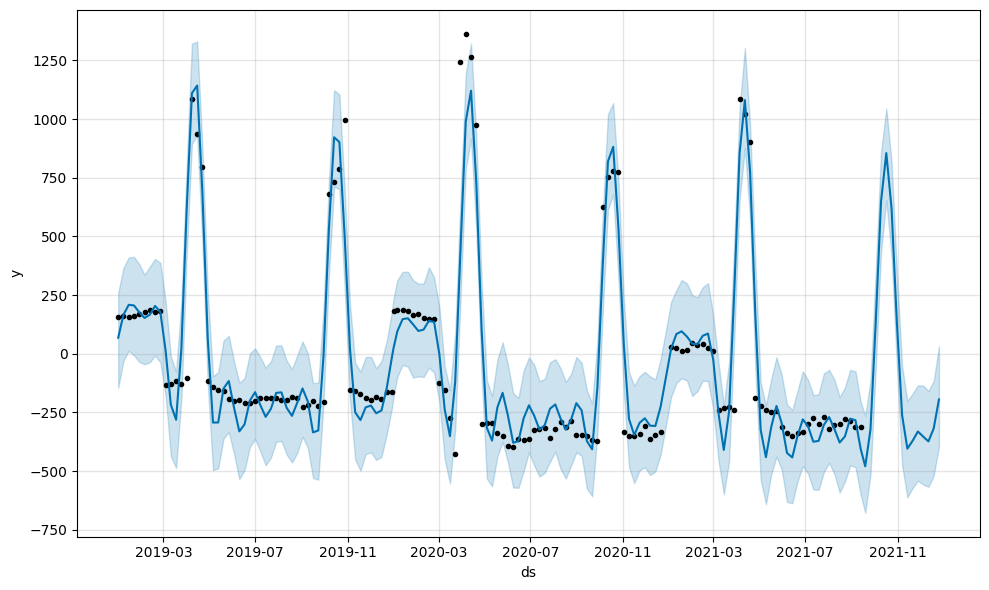

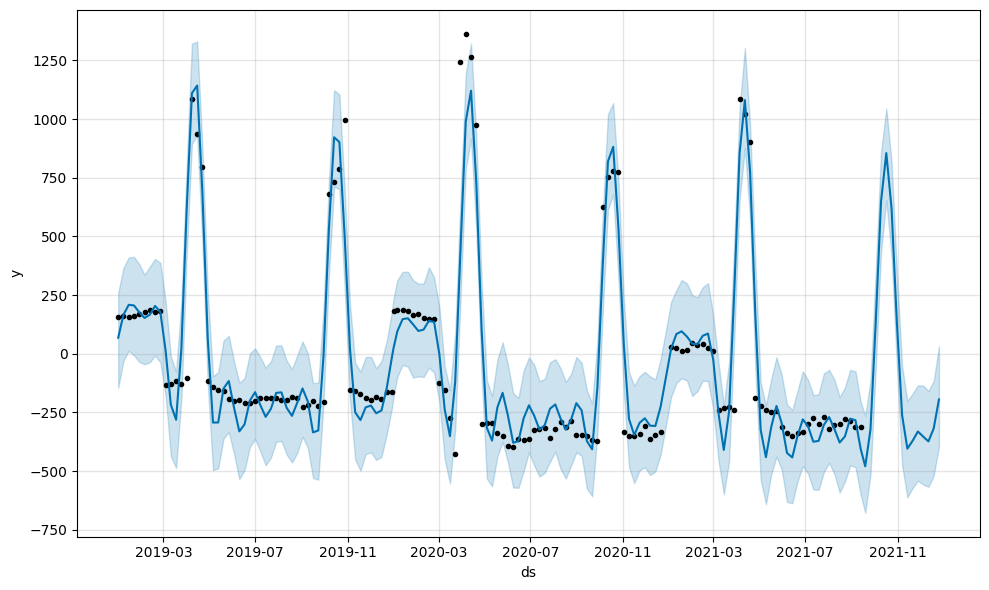

In [ ]:
prophet_model.plot(prophet_forecast_uni)

#Component 4


##Arima

In [ ]:
df_nix=components_df[['Component 4','ds']]
df_nix['unique_id']=1
df_nix.columns= ['y','ds','unique_id']

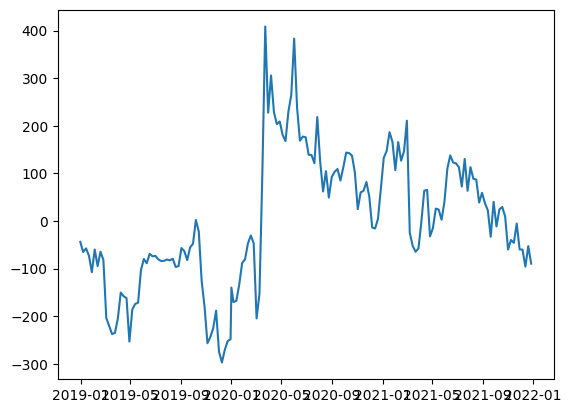

In [ ]:
plt.plot(df_nix['ds'],df_nix['y'])

In [ ]:
train_start = pd.to_datetime("2018-01-01")
train_end = pd.to_datetime("2021-9-16")
test_start = pd.to_datetime("2021-9-19")
test_end = pd.to_datetime("2022-01-01")

In [ ]:
train_df=df_nix[(df_nix["ds"] >= train_start) & (df_nix["ds"] <= train_end)]
test_df = df_nix[(df_nix["ds"] >= test_start) & (df_nix["ds"] <= test_end)]

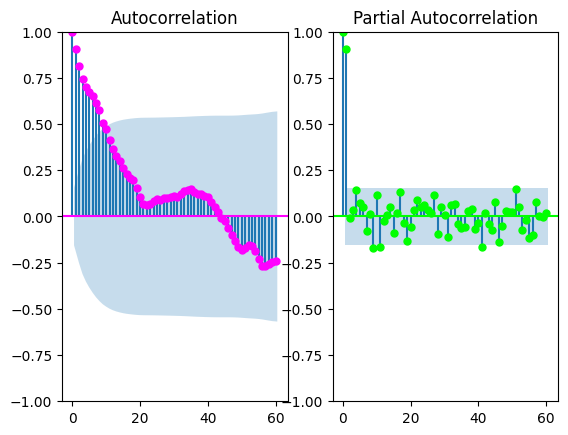

<Figure size 2000x2000 with 0 Axes>

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2)
plt.figure(figsize=(20,20))
plot_acf(df_nix["y"],  lags=60, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation");

plot_pacf(df_nix["y"],  lags=60, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

plt.show();

In [ ]:
models=[
    AutoARIMA(season_length=52)]
sf = StatsForecast(df=train_df,
                   models=models,
                   freq='W',
                   n_jobs=-1)

In [ ]:
sf.fit(train_df)

StatsForecast(models=[AutoARIMA])

In [ ]:
model_params = sf.fitted_[0][0].model_
# model_params


In [ ]:
model_params['loglik']#['loglik']#.coef.loglik

-780.994472130109

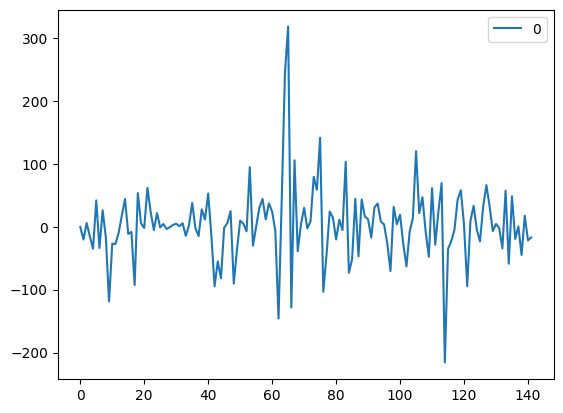

In [ ]:
residuals = pd.DataFrame(model_params["residuals"])
residuals.plot()
plt.show()

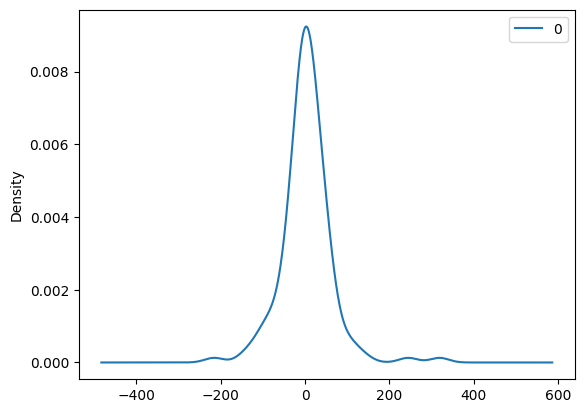

In [ ]:
residuals.plot(kind='kde')
plt.show()

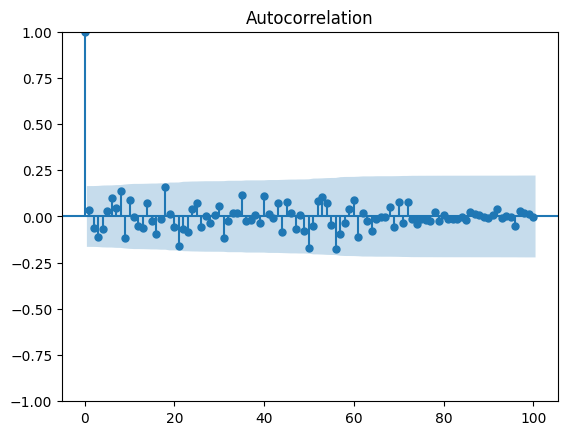

In [ ]:
plot_acf(residuals, lags=100)

plt.show()

In [ ]:
Y_hat = sf.forecast(h=test_df.shape[0],X_df=test_df.drop(['y'],axis=1).reset_index(drop=True),fitted=True)
Y_hat['ds']+= pd.Timedelta(days=1)

In [ ]:
Y_hat.head()

ds  AutoARIMA
unique_id                      
1         2021-09-20  26.263271
1         2021-09-27  29.550438
1         2021-10-04  32.436726
1         2021-10-11  34.971024
1         2021-10-18  37.196255

In [ ]:
test_df.head()

y         ds  unique_id
142 -32.988300 2021-09-20          1
143  40.158098 2021-09-27          1
144 -11.456657 2021-10-04          1
145  24.441613 2021-10-11          1
146  29.476106 2021-10-18          1

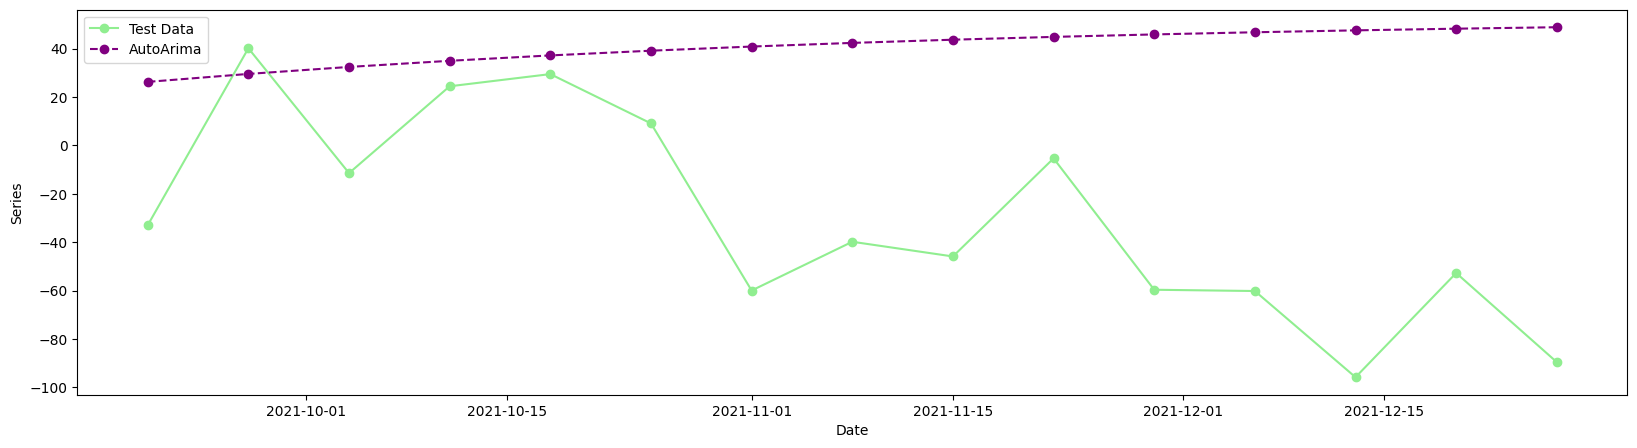

In [ ]:


fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(test_df['ds'], test_df['y'], linestyle='-', marker='o', color='lightgreen', label='Test Data')
ax.plot(Y_hat['ds'], Y_hat['AutoARIMA'], linestyle='--', marker='o', color='purple', label='AutoArima')

ax.set_xlabel('Date')
ax.set_ylabel('Series')

ax.legend()
plt.show()


In [ ]:
test_df.head()


y         ds  unique_id
142 -32.988300 2021-09-20          1
143  40.158098 2021-09-27          1
144 -11.456657 2021-10-04          1
145  24.441613 2021-10-11          1
146  29.476106 2021-10-18          1

In [ ]:

Y_hat.head()

ds  AutoARIMA
unique_id                      
1         2021-09-20  26.263271
1         2021-09-27  29.550438
1         2021-10-04  32.436726
1         2021-10-11  34.971024
1         2021-10-18  37.196255

## Perform 10-fold cross-Validation by training a AutoArima model for each fold

In [ ]:
df_nix=components_df[['Component 4','ds']]
df_nix['unique_id']=1
df_nix.columns= ['y','ds','unique_id']
n_splits = 10
val_size = 14
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=val_size)

In [ ]:
for fold, (train_index, val_index) in enumerate(tscv.split(train_df)):
    print("Fold: {}".format(fold))
    print(f"TRAIN indices: {train_index.min()} to {train_index.max()} \n VALIDATION indices: {val_index.min()} to {val_index.max()}")
    print("\n")

Fold: 0
TRAIN indices: 0 to 1 
 VALIDATION indices: 2 to 15


Fold: 1
TRAIN indices: 0 to 15 
 VALIDATION indices: 16 to 29


Fold: 2
TRAIN indices: 0 to 29 
 VALIDATION indices: 30 to 43


Fold: 3
TRAIN indices: 0 to 43 
 VALIDATION indices: 44 to 57


Fold: 4
TRAIN indices: 0 to 57 
 VALIDATION indices: 58 to 71


Fold: 5
TRAIN indices: 0 to 71 
 VALIDATION indices: 72 to 85


Fold: 6
TRAIN indices: 0 to 85 
 VALIDATION indices: 86 to 99


Fold: 7
TRAIN indices: 0 to 99 
 VALIDATION indices: 100 to 113


Fold: 8
TRAIN indices: 0 to 113 
 VALIDATION indices: 114 to 127


Fold: 9
TRAIN indices: 0 to 127 
 VALIDATION indices: 128 to 141




In [ ]:
mape_ls = []
for fold, (train_index, val_index) in enumerate(tscv.split(train_df)):
  #print(f"TRAIN indices: {train_index.min()} to {train_index.max()} \n VALIDATION indices: {val_index.min()} to {val_index.max()}")
  print("Fold: {}".format(fold))
  train_fold_df = train_df.iloc[train_index]
  val_fold_df = train_df.iloc[val_index]
  models = [ AutoARIMA(season_length=53)]
  sf = StatsForecast(df=train_fold_df,
                    models=models,
                    freq='W',
                    n_jobs=-1)
  sf.fit(train_fold_df)

  Y_hat=sf.forecast(h=val_size,X_df=val_fold_df.drop(['y'],axis=1).reset_index(drop=True),fitted=True)
  Y_hat['ds']+= pd.Timedelta(days=1)
  val_fold_df=val_fold_df.merge(Y_hat, on=['ds'], how='left')

  # if fold==2:
  #  break
  val_fold_df['AutoARIMA'].ffill(inplace=True)

  mape = np.round(100*mean_absolute_percentage_error(val_fold_df["y"],val_fold_df["AutoARIMA"]),2)
  mape_ls.append(mape)
  print(f"The validation MAPE is {mape}%")




Fold: 0
The validation MAPE is 100.0%
Fold: 1
The validation MAPE is 66.57%
Fold: 2
The validation MAPE is 184.9%
Fold: 3
The validation MAPE is 30.33%
Fold: 4
The validation MAPE is 101.68%
Fold: 5
The validation MAPE is 36.69%
Fold: 6
The validation MAPE is 44.02%
Fold: 7
The validation MAPE is 207.81%
Fold: 8
The validation MAPE is 1764.29%
Fold: 9
The validation MAPE is 77.79%


In [ ]:
Y_hat.head()

ds   AutoARIMA
unique_id                       
1         2021-06-14  109.941299
1         2021-06-21  109.941299
1         2021-06-28  109.941299
1         2021-07-05  109.941299
1         2021-07-12  109.941299

In [ ]:
val_fold_df

y         ds  unique_id   AutoARIMA
0   137.835102 2021-06-14          1  109.941299
1   122.763987 2021-06-21          1  109.941299
2   121.027445 2021-06-28          1  109.941299
3   112.855012 2021-07-05          1  109.941299
4    72.314360 2021-07-12          1  109.941299
5   130.375242 2021-07-19          1  109.941299
6    63.367562 2021-07-26          1  109.941299
7   113.248702 2021-08-02          1  109.941299
8    88.650211 2021-08-09          1  109.941299
9    86.992956 2021-08-16          1  109.941299
10   38.681710 2021-08-23          1  109.941299
11   59.297523 2021-08-30          1  109.941299
12   37.358872 2021-09-06          1  109.941299
13   22.519546 2021-09-13          1  109.941299

##prophet

In [ ]:
df_nix=components_df[['Component 4','ds']]

df_nix.columns= ['y','ds']
train_start = pd.to_datetime("2018-01-01")
train_end = pd.to_datetime("2021-9-16")
test_start = pd.to_datetime("2021-9-19")
test_end = pd.to_datetime("2022-01-01")
train_df=df_nix[(df_nix["ds"] >= train_start) & (df_nix["ds"] <= train_end)]
test_df = df_nix[(df_nix["ds"] >= test_start) & (df_nix["ds"] <= test_end)]

In [ ]:
prophet_model = Prophet(#growth='linear',
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=True,
    seasonality_mode='additive').fit(train_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_y0_dpbj/zjbpusqd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_y0_dpbj/wiiyci1m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10339', 'data', 'file=/tmp/tmp_y0_dpbj/zjbpusqd.json', 'init=/tmp/tmp_y0_dpbj/wiiyci1m.json', 'output', 'file=/tmp/tmp_y0_dpbj/prophet_model7lh3veaw/prophet_model-20240620231603.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:16:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:16:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
test_df.shape[0]

15

In [ ]:
future = prophet_model.make_future_dataframe(periods=test_df.shape[0], freq="w")
prophet_forecast_uni = prophet_model.predict(future)


In [ ]:
prophet_forecast_uni[['ds', 'yhat']]

ds        yhat
0   2018-12-31 -201.218593
1   2019-01-07 -138.508538
2   2019-01-14 -117.067806
3   2019-01-21 -123.466652
4   2019-01-28 -124.515236
..         ...         ...
152 2021-11-28   73.025980
153 2021-12-05   30.267582
154 2021-12-12   -9.567615
155 2021-12-19   -3.870077
156 2021-12-26   55.121788

[157 rows x 2 columns]

In [ ]:
to_plot=prophet_forecast_uni[['ds', 'yhat']]
to_plot=to_plot[(to_plot["ds"] >= test_start )& (to_plot["ds"] <= test_end)]
to_plot['ds']+=pd.Timedelta(days=1)

In [ ]:
predicted_components_df['Component 4']=to_plot['yhat']

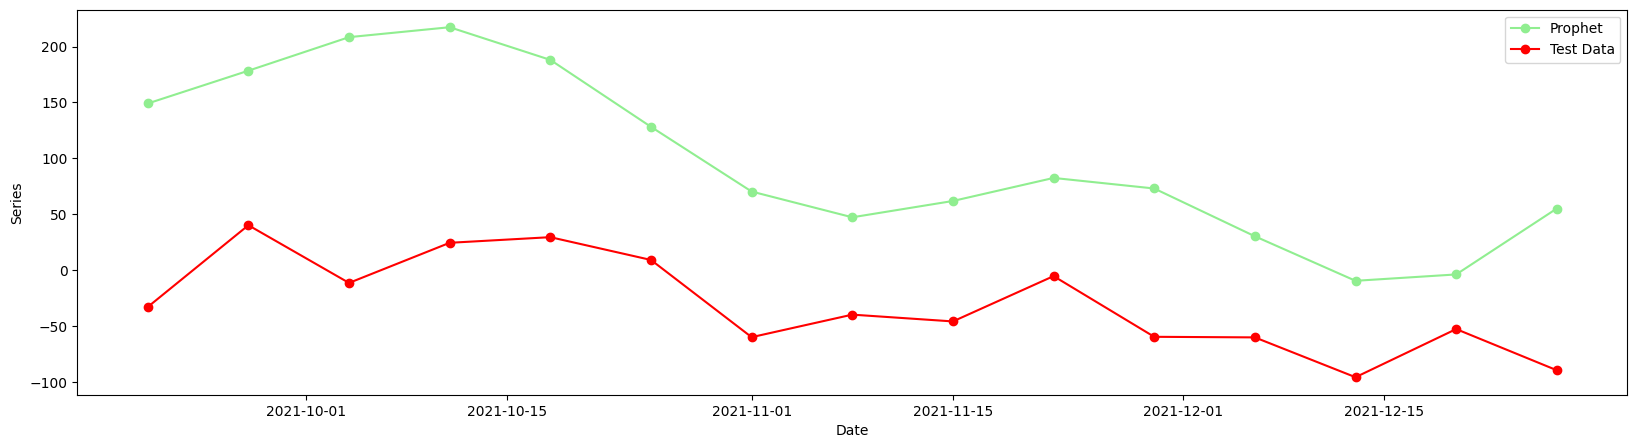

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(to_plot['ds'], to_plot['yhat'], linestyle='-', marker='o', color='lightgreen', label='Prophet')
ax.plot(test_df['ds'], test_df['y'], linestyle='-', marker='o', color='Red', label='Test Data')

ax.set_xlabel('Date')
ax.set_ylabel('Series')

ax.legend()
plt.show()


##Time Series Cross Validation for prophet

In [ ]:
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
df_nix=components_df[['Component 3','ds']]
df_nix['unique_id']=1
df_nix.columns= ['y','ds','unique_id']
prophet_df=df_nix[['ds','y']]
prophet_df.columns=['ds','y']
prophet_df['ds']=pd.to_datetime(prophet_df['ds'])
df = prophet_df
total_length = len(df)
window_size = total_length // 10
results = {}
for component in df.columns[1:]:
    component_df = df[['ds', component]].rename(columns={'Date': 'ds', component: 'y'})


    model = Prophet(#growth='linear',
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=True,
    seasonality_mode='additive')
    model.fit(component_df)


    df_cv =  cross_validation(model, initial=f'364 days', horizon='364 days')


    df_p = performance_metrics(df_cv)


    results[component] = df_p


for component, metrics in results.items():
    print(f"Results for component: {component}")
    metrics.drop('mse',axis=1,inplace=True)
    print(metrics)
    print("\n")



DEBUG:cmdstanpy:input tempfile: /tmp/tmp_y0_dpbj/erijygvu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_y0_dpbj/kc5l6tvt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96458', 'data', 'file=/tmp/tmp_y0_dpbj/erijygvu.json', 'init=/tmp/tmp_y0_dpbj/kc5l6tvt.json', 'output', 'file=/tmp/tmp_y0_dpbj/prophet_modelvtitei94/prophet_model-20240620231624.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:16:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:16:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2019-12-30 00:00:00 and 2020-12-28 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_y0_dpbj/q8pl6lxa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_y0_dpbj/r8glof85.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30941', 'data', 'file=/tmp/tmp_y0_dpbj/q8pl6lxa.json', 'init=/tmp/tmp_y0_dpbj/r8glof85.json', 'output', 'file=/tmp/tmp_y0_dpbj/prophet_modelv3gwiicn/prophet_model-20240620231624.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:16:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:16:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_y0_dpbj/e58yyv9u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_y0_dpbj/xhhls7j0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

Results for component: y
    horizon        rmse         mae      mape     mdape     smape  coverage
0   35 days  208.665137  163.121456  1.761371  1.775148  1.117999  0.666667
1   42 days  203.436950  159.921230  1.767006  1.775148  1.115919  0.666667
2   49 days  196.816768  153.965365  1.644819  0.893337  1.078063  0.666667
3   56 days  193.050092  147.258005  1.176265  0.893337  1.017989  0.666667
4   63 days  179.532612  137.164377  1.464078  0.893337  0.976930  0.733333
5   70 days  179.557614  140.285231  1.471932  0.893337  0.901210  0.733333
6   77 days  190.492466  155.325025  1.467974  0.906092  0.845463  0.666667
7   84 days  174.701960  139.835226  1.286913  0.538842  0.687580  0.733333
8   91 days  415.403205  257.337962  1.301434  0.702618  0.826400  0.600000
9   98 days  490.347806  327.306572  0.716124  0.523487  0.721514  0.466667
10 105 days  508.714757  341.236991  0.578847  0.413681  0.646358  0.466667
11 112 days  519.851217  356.280055  0.485211  0.221543  0.6139

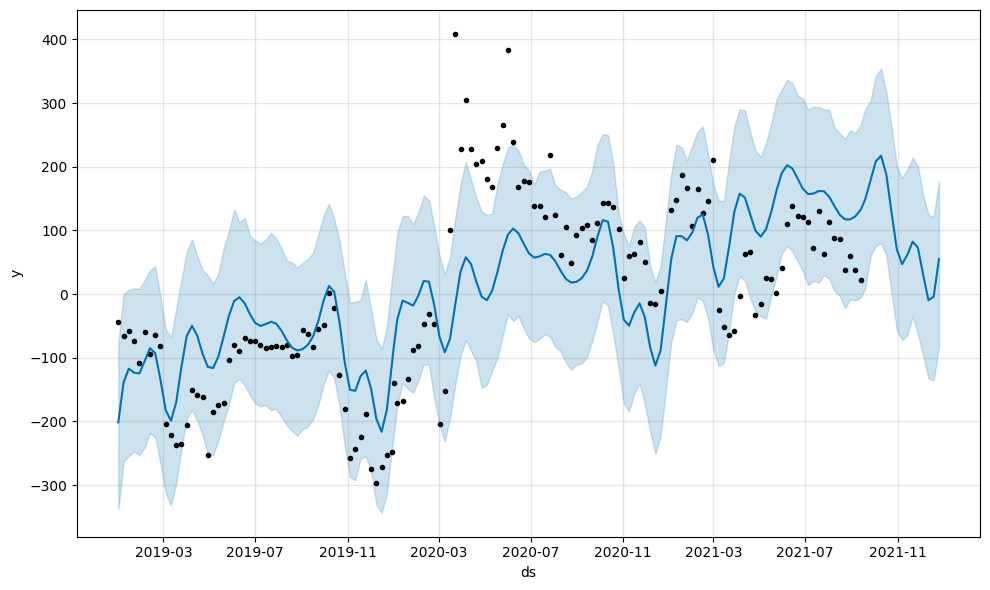

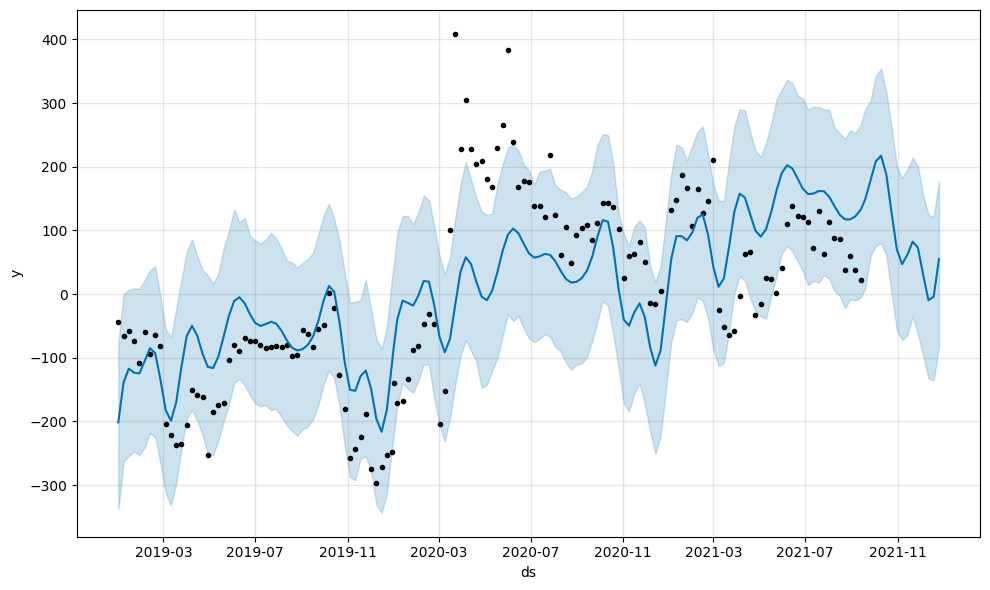

In [ ]:
prophet_model.plot(prophet_forecast_uni)

#Component 5


##Arima

In [ ]:
df_nix=components_df[['Component 5','ds']]
df_nix['unique_id']=1
df_nix.columns= ['y','ds','unique_id']

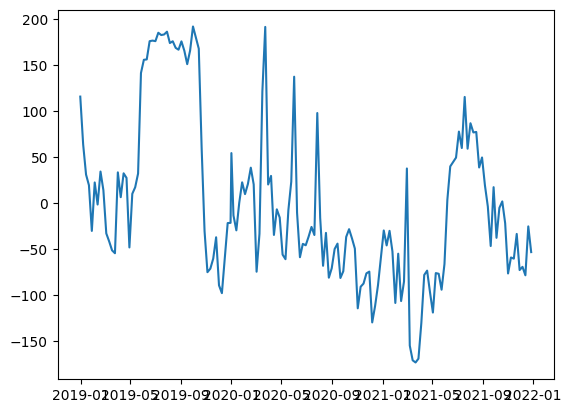

In [ ]:
plt.plot(df_nix['ds'],df_nix['y'])

In [ ]:
train_start = pd.to_datetime("2018-01-01")
train_end = pd.to_datetime("2021-9-16")
test_start = pd.to_datetime("2021-9-19")
test_end = pd.to_datetime("2022-01-01")

In [ ]:
train_df=df_nix[(df_nix["ds"] >= train_start) & (df_nix["ds"] <= train_end)]
test_df = df_nix[(df_nix["ds"] >= test_start) & (df_nix["ds"] <= test_end)]

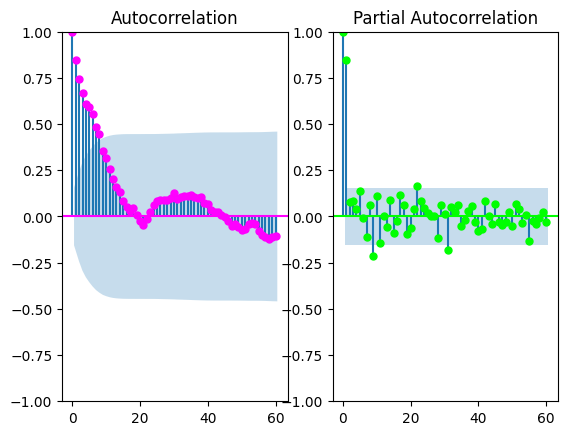

<Figure size 2000x2000 with 0 Axes>

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2)
plt.figure(figsize=(20,20))
plot_acf(df_nix["y"],  lags=60, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation");

plot_pacf(df_nix["y"],  lags=60, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

plt.show();

In [ ]:
models=[
    AutoARIMA(season_length=53)]
sf = StatsForecast(df=train_df,
                   models=models,
                   freq='W',
                   n_jobs=-1)

In [ ]:
sf.fit(train_df)

StatsForecast(models=[AutoARIMA])

In [ ]:
model_params = sf.fitted_[0][0].model_
# model_params


In [ ]:
model_params['loglik']#['loglik']#.coef.loglik

-746.7453898608688

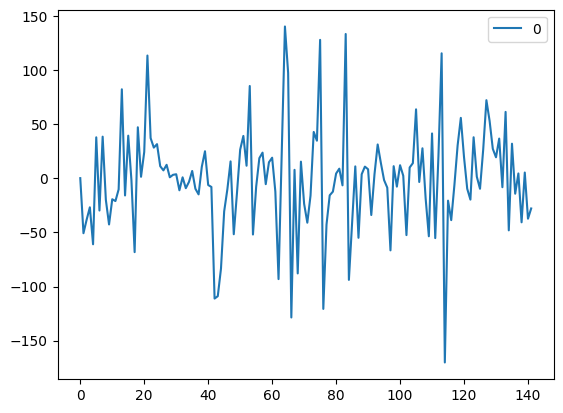

In [ ]:
residuals = pd.DataFrame(model_params["residuals"])
residuals.plot()
plt.show()

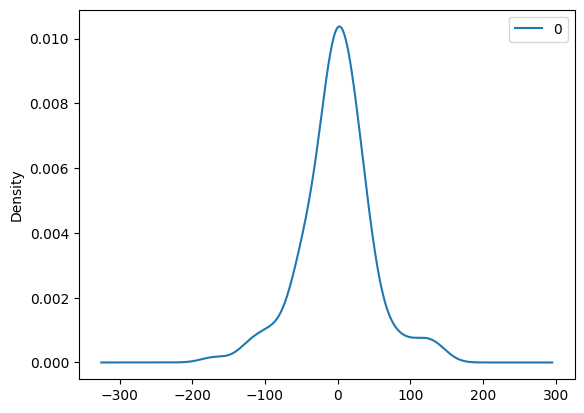

In [ ]:
residuals.plot(kind='kde')
plt.show()

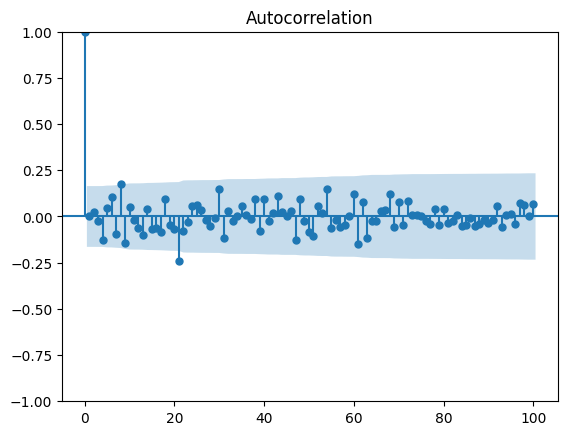

In [ ]:
plot_acf(residuals, lags=100)

plt.show()

In [ ]:
Y_hat = sf.forecast(h=test_df.shape[0],X_df=test_df.drop(['y'],axis=1).reset_index(drop=True),fitted=True)
Y_hat['ds']+= pd.Timedelta(days=1)

In [ ]:
Y_hat.head()

ds  AutoARIMA
unique_id                      
1         2021-09-20   7.657207
1         2021-09-27  13.069343
1         2021-10-04  13.069343
1         2021-10-11  13.069343
1         2021-10-18  13.069343

In [ ]:
test_df.head()

y         ds  unique_id
142 -46.998639 2021-09-20          1
143  16.950391 2021-09-27          1
144 -38.088800 2021-10-04          1
145  -5.560292 2021-10-11          1
146   1.472945 2021-10-18          1

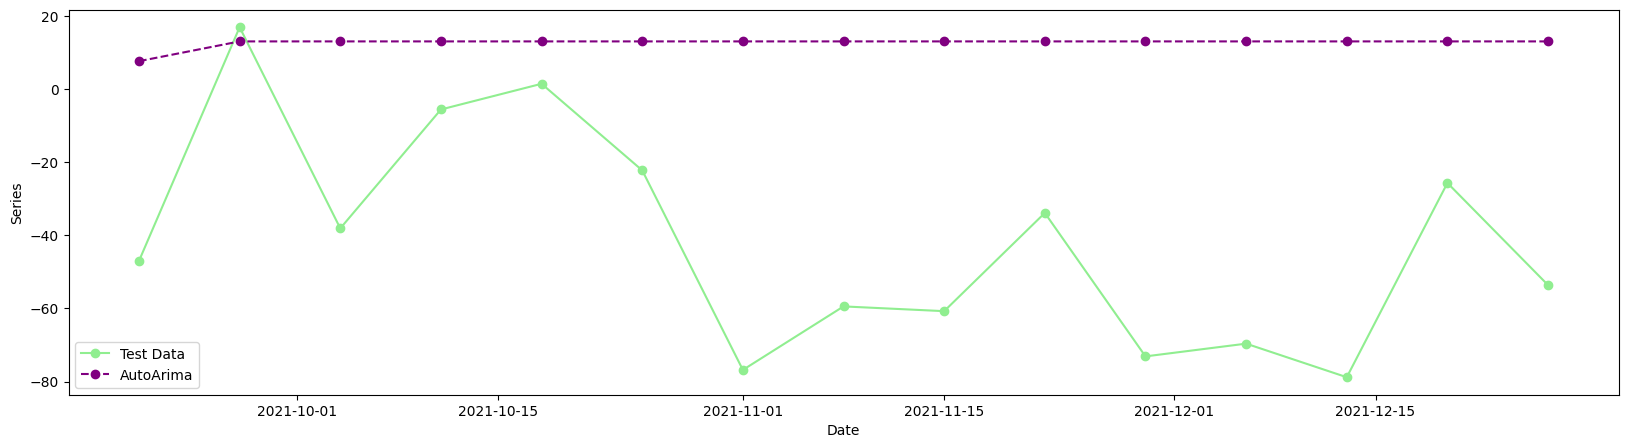

In [ ]:


fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(test_df['ds'], test_df['y'], linestyle='-', marker='o', color='lightgreen', label='Test Data')
ax.plot(Y_hat['ds'], Y_hat['AutoARIMA'], linestyle='--', marker='o', color='purple', label='AutoArima')

ax.set_xlabel('Date')
ax.set_ylabel('Series')

ax.legend()
plt.show()


In [ ]:
test_df.head()


y         ds  unique_id
142 -46.998639 2021-09-20          1
143  16.950391 2021-09-27          1
144 -38.088800 2021-10-04          1
145  -5.560292 2021-10-11          1
146   1.472945 2021-10-18          1

In [ ]:

Y_hat.head()

ds  AutoARIMA
unique_id                      
1         2021-09-20   7.657207
1         2021-09-27  13.069343
1         2021-10-04  13.069343
1         2021-10-11  13.069343
1         2021-10-18  13.069343

## Perform 10-fold cross-Validation by training a AutoArima model for each fold

In [ ]:
df_nix=components_df[['Component 5','ds']]
df_nix['unique_id']=1
df_nix.columns= ['y','ds','unique_id']
n_splits = 10
val_size = 14
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=val_size)

In [ ]:
for fold, (train_index, val_index) in enumerate(tscv.split(train_df)):
    print("Fold: {}".format(fold))
    print(f"TRAIN indices: {train_index.min()} to {train_index.max()} \n VALIDATION indices: {val_index.min()} to {val_index.max()}")
    print("\n")

Fold: 0
TRAIN indices: 0 to 1 
 VALIDATION indices: 2 to 15


Fold: 1
TRAIN indices: 0 to 15 
 VALIDATION indices: 16 to 29


Fold: 2
TRAIN indices: 0 to 29 
 VALIDATION indices: 30 to 43


Fold: 3
TRAIN indices: 0 to 43 
 VALIDATION indices: 44 to 57


Fold: 4
TRAIN indices: 0 to 57 
 VALIDATION indices: 58 to 71


Fold: 5
TRAIN indices: 0 to 71 
 VALIDATION indices: 72 to 85


Fold: 6
TRAIN indices: 0 to 85 
 VALIDATION indices: 86 to 99


Fold: 7
TRAIN indices: 0 to 99 
 VALIDATION indices: 100 to 113


Fold: 8
TRAIN indices: 0 to 113 
 VALIDATION indices: 114 to 127


Fold: 9
TRAIN indices: 0 to 127 
 VALIDATION indices: 128 to 141




In [ ]:
mape_ls = []
for fold, (train_index, val_index) in enumerate(tscv.split(train_df)):
  #print(f"TRAIN indices: {train_index.min()} to {train_index.max()} \n VALIDATION indices: {val_index.min()} to {val_index.max()}")
  print("Fold: {}".format(fold))
  train_fold_df = train_df.iloc[train_index]
  val_fold_df = train_df.iloc[val_index]
  models = [ AutoARIMA(season_length=53)]
  sf = StatsForecast(df=train_fold_df,
                    models=models,
                    freq='W',
                    n_jobs=-1)
  sf.fit(train_fold_df)

  Y_hat=sf.forecast(h=val_size,X_df=val_fold_df.drop(['y'],axis=1).reset_index(drop=True),fitted=True)
  Y_hat['ds']+= pd.Timedelta(days=1)
  val_fold_df=val_fold_df.merge(Y_hat, on=['ds'], how='left')

  # if fold==2:
  #  break
  val_fold_df['AutoARIMA'].ffill(inplace=True)

  mape = np.round(100*mean_absolute_percentage_error(val_fold_df["y"],val_fold_df["AutoARIMA"]),2)
  mape_ls.append(mape)
  print(f"The validation MAPE is {mape}%")




Fold: 0
The validation MAPE is 100.0%
Fold: 1
The validation MAPE is 88.03%
Fold: 2
The validation MAPE is 71.16%
Fold: 3
The validation MAPE is 38957.7%
Fold: 4
The validation MAPE is 336.22%
Fold: 5
The validation MAPE is 159.17%
Fold: 6
The validation MAPE is 47.74%
Fold: 7
The validation MAPE is 75.51%
Fold: 8
The validation MAPE is 203.5%
Fold: 9
The validation MAPE is 202.64%


In [ ]:
Y_hat.head()

ds  AutoARIMA
unique_id                      
1         2021-06-14 -15.357062
1         2021-06-21 -33.059879
1         2021-06-28 -33.059879
1         2021-07-05 -33.059879
1         2021-07-12 -33.059879

In [ ]:
val_fold_df

y         ds  unique_id  AutoARIMA
0    39.518687 2021-06-14          1 -15.357062
1    44.303336 2021-06-21          1 -33.059879
2    49.072871 2021-06-28          1 -33.059879
3    77.358731 2021-07-05          1 -33.059879
4    59.507209 2021-07-12          1 -33.059879
5   115.011491 2021-07-19          1 -33.059879
6    58.757349 2021-07-26          1 -33.059879
7    86.439144 2021-08-02          1 -33.059879
8    76.439248 2021-08-09          1 -33.059879
9    76.964312 2021-08-16          1 -33.059879
10   38.340360 2021-08-23          1 -33.059879
11   49.248881 2021-08-30          1 -33.059879
12   18.944124 2021-09-06          1 -33.059879
13   -4.029310 2021-09-13          1 -33.059879

##prophet

In [ ]:
df_nix=components_df[['Component 5','ds']]

df_nix.columns= ['y','ds']
train_start = pd.to_datetime("2018-01-01")
train_end = pd.to_datetime("2021-9-16")
test_start = pd.to_datetime("2021-9-19")
test_end = pd.to_datetime("2022-01-01")
train_df=df_nix[(df_nix["ds"] >= train_start) & (df_nix["ds"] <= train_end)]
test_df = df_nix[(df_nix["ds"] >= test_start) & (df_nix["ds"] <= test_end)]

In [ ]:
prophet_model = Prophet(#growth='linear',
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=True,
    seasonality_mode='additive').fit(train_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_y0_dpbj/br2wy_8x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_y0_dpbj/3x7fqod9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9957', 'data', 'file=/tmp/tmp_y0_dpbj/br2wy_8x.json', 'init=/tmp/tmp_y0_dpbj/3x7fqod9.json', 'output', 'file=/tmp/tmp_y0_dpbj/prophet_modelwqyz1hud/prophet_model-20240620231736.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:17:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:17:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
test_df.shape[0]

15

In [ ]:
future = prophet_model.make_future_dataframe(periods=test_df.shape[0], freq="w")
prophet_forecast_uni = prophet_model.predict(future)


In [ ]:
prophet_forecast_uni[['ds', 'yhat']]

ds        yhat
0   2018-12-31   69.597272
1   2019-01-07   72.945989
2   2019-01-14   49.669036
3   2019-01-21   27.030353
4   2019-01-28   24.789266
..         ...         ...
152 2021-11-28 -151.066493
153 2021-12-05 -173.743480
154 2021-12-12 -180.336214
155 2021-12-19 -153.646409
156 2021-12-26 -110.149598

[157 rows x 2 columns]

In [ ]:
to_plot=prophet_forecast_uni[['ds', 'yhat']]
to_plot=to_plot[(to_plot["ds"] >= test_start )& (to_plot["ds"] <= test_end)]
to_plot['ds']+=pd.Timedelta(days=1)

In [ ]:
predicted_components_df['Component 5']=to_plot['yhat']

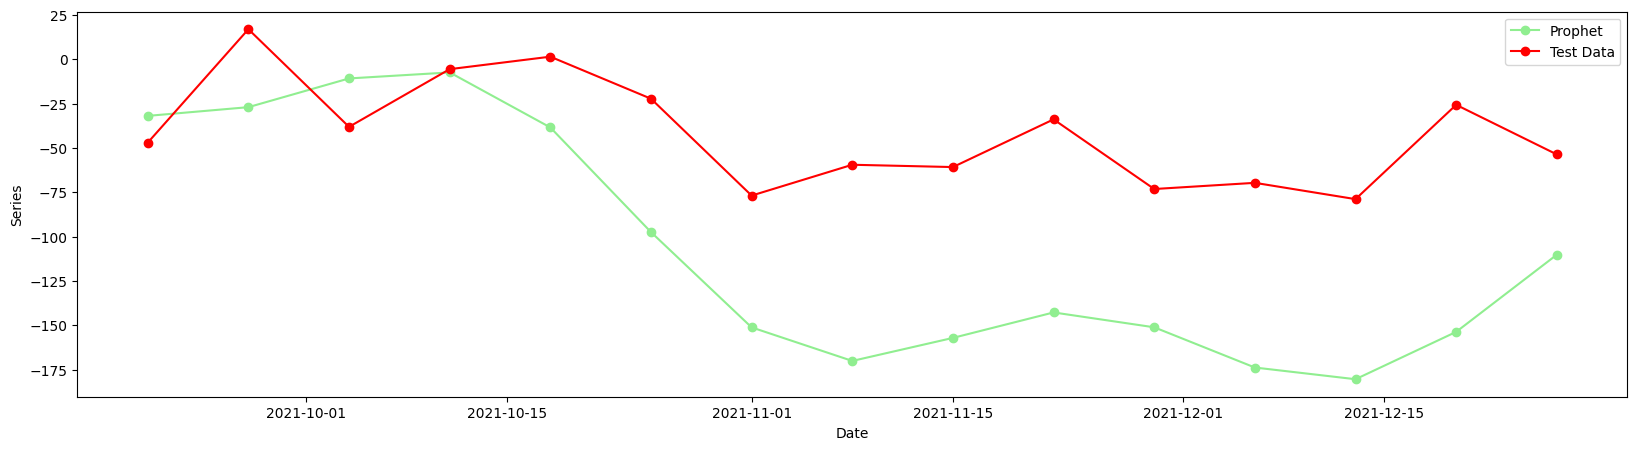

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(to_plot['ds'], to_plot['yhat'], linestyle='-', marker='o', color='lightgreen', label='Prophet')
ax.plot(test_df['ds'], test_df['y'], linestyle='-', marker='o', color='Red', label='Test Data')

ax.set_xlabel('Date')
ax.set_ylabel('Series')

ax.legend()
plt.show()


##Time Series Cross Validation for prophet

In [ ]:
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
df_nix=components_df[['Component 5','ds']]
df_nix['unique_id']=1
df_nix.columns= ['y','ds','unique_id']
prophet_df=df_nix[['ds','y']]
prophet_df.columns=['ds','y']
prophet_df['ds']=pd.to_datetime(prophet_df['ds'])
df = prophet_df
total_length = len(df)
window_size = total_length // 10
results = {}
for component in df.columns[1:]:
    component_df = df[['ds', component]].rename(columns={'Date': 'ds', component: 'y'})


    model = Prophet(#growth='linear',
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=True,
    seasonality_mode='additive')
    model.fit(component_df)


    df_cv =  cross_validation(model, initial=f'364 days', horizon='364 days')


    df_p = performance_metrics(df_cv)


    results[component] = df_p


for component, metrics in results.items():
    print(f"Results for component: {component}")
    metrics.drop('mse',axis=1,inplace=True)
    print(metrics)
    print("\n")



DEBUG:cmdstanpy:input tempfile: /tmp/tmp_y0_dpbj/ce5t9bbe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_y0_dpbj/9fsb8o77.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88067', 'data', 'file=/tmp/tmp_y0_dpbj/ce5t9bbe.json', 'init=/tmp/tmp_y0_dpbj/9fsb8o77.json', 'output', 'file=/tmp/tmp_y0_dpbj/prophet_model_cndff47/prophet_model-20240620231816.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:18:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:18:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2019-12-30 00:00:00 and 2020-12-28 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_y0_dpbj/lbram5zz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_y0_dpbj/0u0okyli.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73517', 'data', 'file=/tmp/tmp_y0_dpbj/lbram5zz.json', 'init=/tmp/tmp_y0_dpbj/0u0okyli.json', 'output', 'file=/tmp/tmp_y0_dpbj/prophet_model_puumr0z/prophet_model-20240620231816.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:18:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:18:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_y0_dpbj/krfzc0r9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_y0_dpbj/jw8159uc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

Results for component: y
    horizon        rmse         mae        mape     mdape     smape  coverage
0   35 days  120.304721  107.379753  306.030429  4.111700  1.383194  0.200000
1   42 days  128.591546  116.878066  306.173820  4.233424  1.431717  0.200000
2   49 days  130.355146  117.680631  306.079899  4.233424  1.449447  0.266667
3   56 days  130.976681  116.345993    4.140112  2.898194  1.398227  0.266667
4   63 days  143.720127  127.804900    4.132974  2.898194  1.480109  0.200000
5   70 days  145.384536  128.470906    3.082368  2.898194  1.426270  0.200000
6   77 days  158.219015  136.379489    2.832637  2.844946  1.398828  0.200000
7   84 days  182.983567  156.487416    2.548591  2.593886  1.417699  0.200000
8   91 days  183.743940  156.898839    2.593772  2.593886  1.406269  0.266667
9   98 days  176.799077  146.641864    2.603720  2.593886  1.369900  0.333333
10 105 days  173.315968  143.335276    2.606900  2.477413  1.372486  0.333333
11 112 days  154.216377  127.434786    

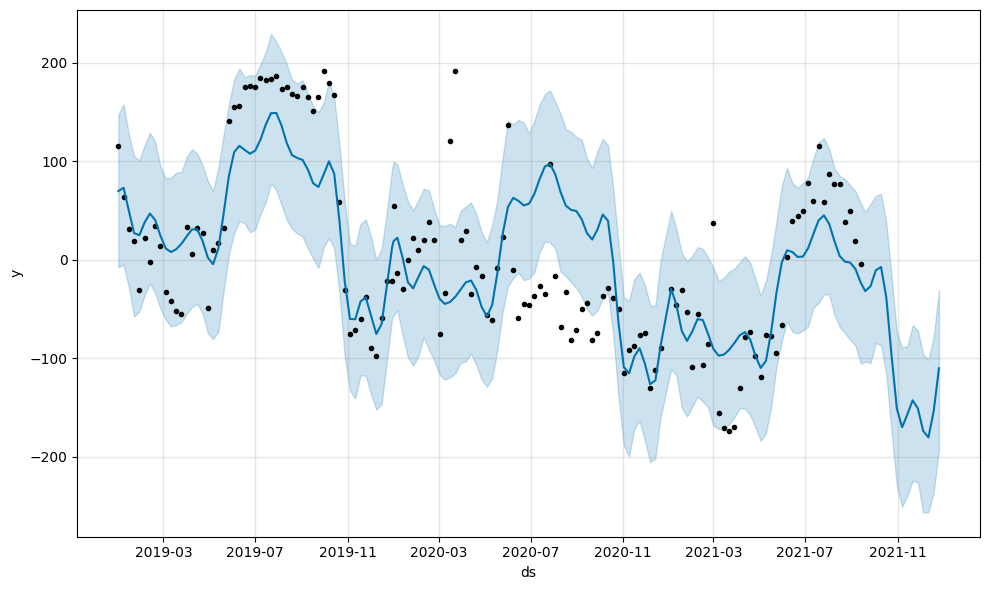

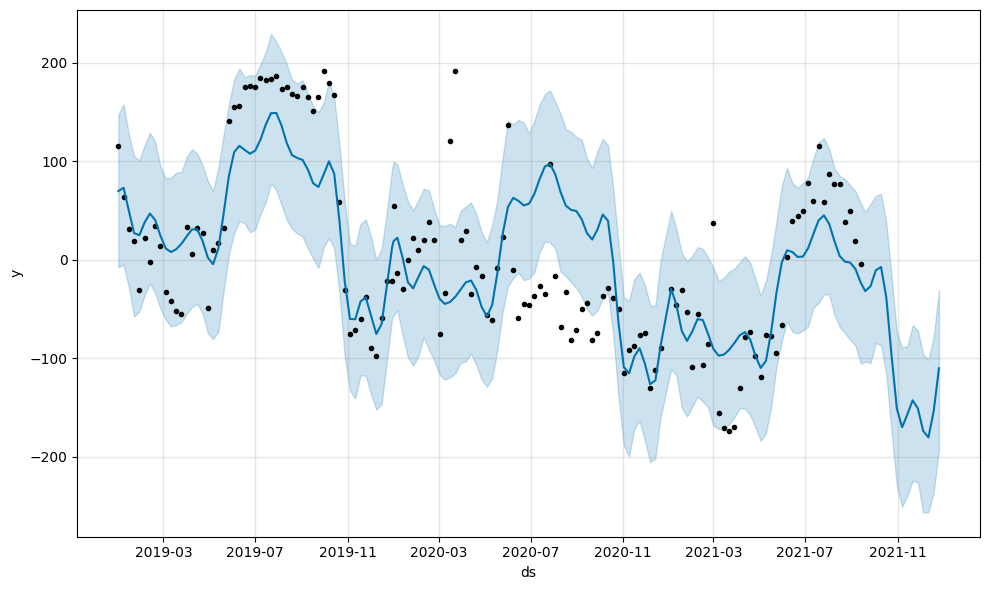

In [ ]:
prophet_model.plot(prophet_forecast_uni)

#Inverse Transformation of the SVD Signifincant compotents to predicted Values for all 497 locations

In [ ]:
predicted_components_df['ds']=to_plot['ds']

In [ ]:
predicted_components_df

ds  Component 1  Component 2  Component 3  Component 4  \
142 2021-09-20  3531.428846  -351.840261  -479.670339   149.079508   
143 2021-09-27  3629.662541  -397.565154  -322.002228   178.418452   
144 2021-10-04  3856.571901  -536.855958   137.647518   208.436484   
145 2021-10-11  4121.077015  -646.850706   648.777446   217.318633   
146 2021-10-18  4241.262525  -638.385982   855.123523   188.090330   
147 2021-10-25  4114.274932  -555.397842   618.632855   128.199391   
148 2021-11-01  3826.956209  -494.789114   136.173122    70.303578   
149 2021-11-08  3583.899711  -469.386651  -261.766785    47.251886   
150 2021-11-15  3520.167045  -415.083537  -404.450151    61.852316   
151 2021-11-22  3586.814848  -332.289353  -370.956677    82.471758   
152 2021-11-29  3619.863917  -337.549714  -331.325992    73.025980   
153 2021-12-06  3515.439541  -500.252667  -352.948512    30.267582   
154 2021-12-13  3334.471130  -652.674326  -373.505260    -9.567615   
155 2021-12-20  3242.393049  -466.732222  -318.455695    -3.870077   
156 2021-12-27  3354.198444   206.408778  -194.657222    55.121788   

     Component 5  
142   -31.896280  
143   -26.983504  
144   -10.789500  
145    -7.402512  
146   -38.415415  
147   -97.402033  
148  -151.114238  
149  -170.025892  
150  -157.044955  
151  -142.690567  
152  -151.064753  
153  -173.741613  
154  -180.334313  
155  -153.644650  
156  -110.148068

In [ ]:
backup=predicted_components_df.copy(deep=True)

In [ ]:
predicted_components_df=backup
predicted_components_df.reset_index(drop=True)

ds  Component 1  Component 2  Component 3  Component 4  Component 5
0  2021-09-20  3531.428846  -351.840261  -479.670339   149.079508   -31.896280
1  2021-09-27  3629.662541  -397.565154  -322.002228   178.418452   -26.983504
2  2021-10-04  3856.571901  -536.855958   137.647518   208.436484   -10.789500
3  2021-10-11  4121.077015  -646.850706   648.777446   217.318633    -7.402512
4  2021-10-18  4241.262525  -638.385982   855.123523   188.090330   -38.415415
5  2021-10-25  4114.274932  -555.397842   618.632855   128.199391   -97.402033
6  2021-11-01  3826.956209  -494.789114   136.173122    70.303578  -151.114238
7  2021-11-08  3583.899711  -469.386651  -261.766785    47.251886  -170.025892
8  2021-11-15  3520.167045  -415.083537  -404.450151    61.852316  -157.044955
9  2021-11-22  3586.814848  -332.289353  -370.956677    82.471758  -142.690567
10 2021-11-29  3619.863917  -337.549714  -331.325992    73.025980  -151.064753
11 2021-12-06  3515.439541  -500.252667  -352.948512    30.267582  -173.741613
12 2021-12-13  3334.471130  -652.674326  -373.505260    -9.567615  -180.334313
13 2021-12-20  3242.393049  -466.732222  -318.455695    -3.870077  -153.644650
14 2021-12-27  3354.198444   206.408778  -194.657222    55.121788  -110.148068

In [ ]:

useful_columns = ['emission', 'week_no', 'year', 'latitude', 'longitude','ds']


data_filtered = full_df[useful_columns]

pivoted_data = data_filtered.pivot_table(index=['year', 'week_no'], columns=['latitude', 'longitude'], values='emission', aggfunc='mean')
#pivoted_data['date'] = pivoted_data.index.to_series().apply(lambda x: pd.to_datetime(str(x[0]) +str(x[1]) + '1', format='%Y%W%w'))

In [ ]:
pivoted_data

latitude         -3.299     -3.287     -3.174    -3.161     -3.153     -3.138  \
longitude        30.301     29.713     29.926    28.839     30.347     30.662   
year week_no                                                                    
2019 0        26.111166  39.696404  41.193130  0.106631  15.069341  23.184301   
     1        28.045977  43.529408  43.877285  0.112878  16.217907  24.404161   
     2        29.293518  45.993286  45.760826  0.118181  16.811665  25.097378   
     3        29.950650  47.163128  46.675327  0.119753  17.231894  25.591475   
     4        30.572742  48.742470  47.317184  0.119364  17.642060  25.756530   
...                 ...        ...        ...       ...        ...        ...   
2021 48       29.404171  47.328110  46.265680  0.136397  16.179245  25.387463   
     49       29.186497  46.860140  45.971810  0.135066  16.033224  25.222624   
     50       29.131205  46.808056  45.675720  0.131848  16.150730  25.175623   
     51       28.125792  44.268930  44.668972  0.129899  15.336843  24.652740   
     52       27.239302  43.260082  42.904007  0.122683  15.040095  23.723250   

latitude         -3.136      -3.133     -3.099    -3.095  ...     -0.653  \
longitude        30.364      29.467     29.601    29.505  ...     30.447   
year week_no                                              ...              
2019 0        14.774838  105.982190  69.826860  5.375411  ...  28.108765   
     1        15.337234  113.068474  74.357560  5.420106  ...  29.032100   
     2        15.730142  118.279810  77.722220  5.327792  ...  29.870031   
     3        15.979696  120.618580  79.239920  5.422680  ...  30.415354   
     4        15.905249  122.382960  80.324270  5.316918  ...  30.567698   
...                 ...         ...        ...       ...  ...        ...   
2021 48       15.999958  121.018890  79.402374  4.271950  ...  31.397772   
     49       15.933588  120.277370  78.948320  4.265256  ...  31.508383   
     50       15.800288  119.299240  78.301430  4.360768  ...  31.436537   
     51       15.822737  116.869385  76.902200  4.381984  ...  32.232227   
     52       15.027816  112.064705  73.667816  4.234104  ...  30.540236   

latitude         -0.637      -0.627     -0.615     -0.604    -0.598  \
longitude        30.763      29.773     30.885     29.896    29.102   
year week_no                                                          
2019 0        40.153328  101.643295  76.600110  64.494600  0.076542   
     1        41.531597  109.828674  82.630714  68.422940  0.081001   
     2        42.774483  115.189064  86.668290  71.011550  0.084788   
     3        43.542730  117.846870  88.741880  72.571780  0.085920   
     4        43.739470  120.702270  91.137010  73.834610  0.085650   
...                 ...         ...        ...        ...       ...   
2021 48       45.268314  120.687530  90.329790  72.756820  0.097723   
     49       45.388042  119.703354  89.789320  72.485700  0.096784   
     50       45.220715  119.317276  89.738230  72.509610  0.094502   
     51       46.249325  114.708620  86.832870  71.287040  0.093149   
     52       43.812817  111.180580  84.161446  68.697105  0.087978   

latitude          -0.569    -0.547    -0.528    -0.510  
longitude         30.031    29.653    29.472    29.290  
year week_no                                            
2019 0        100.382980  0.500023  3.857115  3.750994  
     1        106.375980  0.529315  4.213432  4.025176  
     2        110.766335  0.554183  4.451489  4.231381  
     3        113.097940  0.561553  4.553981  4.305286  
     4        114.985886  0.559731  4.676066  4.347317  
...                  ...       ...       ...       ...  
2021 48       116.865940  0.639599  4.770357  4.736880  
     49       116.537730  0.633356  4.718280  4.687898  
     50       116.176040  0.618269  4.683615  4.607418  
     51       115.053840  0.609128  4.450044  4.470275  
     52       110.330900  0.575292  4.318747  4.269510  

[157 r

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD




predicted_components = predicted_components_df.drop(columns=['ds']).values


inverse_transformed_data = svd.inverse_transform(predicted_components)


reconstructed_df = pd.DataFrame(inverse_transformed_data, columns=pivoted_data.columns)


reconstructed_df['ds'] = predicted_components_df['ds'].values

# Display the reconstructed DataFrame
reconstructed_df.head()


latitude      -3.299     -3.287     -3.174    -3.161     -3.153     -3.138  \
longitude     30.301     29.713     29.926    28.839     30.347     30.662   
0          29.505417  44.344630  49.737756  0.148691  13.849300  24.838584   
1          29.327419  43.888209  49.662403  0.148530  13.549008  24.618526   
2          28.662185  42.523618  48.713175  0.144251  13.043490  24.071737   
3          28.076745  41.572575  47.597067  0.137867  12.744161  23.507107   
4          28.034032  42.091617  47.002451  0.132576  12.931857  23.189660   

latitude      -3.136      -3.133     -3.099    -3.095  ...     -0.637  \
longitude     30.364      29.467     29.601    29.505  ...     30.763   
0          17.779843  133.396313  88.478542  3.568924  ...  57.377681   
1          17.791210  133.528805  88.647636  3.435830  ...  58.491699   
2          17.576976  131.287739  87.305374  3.326948  ...  59.808052   
3          17.189575  128.431952  85.501801  3.242892  ...  60.523795   
4          16.722229  126.745556  84.314522  3.153037  ...  59.745205   

latitude       -0.627     -0.615     -0.604    -0.598      -0.569    -0.547  \
longitude      29.773     30.885     29.896    29.102      30.031    29.653   
0          118.393848  92.573740  77.460756  0.106775  131.246293  0.697254   
1          117.758325  92.657075  77.744878  0.106693  132.419768  0.696499   
2          115.195865  91.822216  77.628066  0.103704  132.935391  0.676436   
3          113.046922  91.298988  77.492876  0.099208  132.964116  0.646501   
4          113.206621  91.820131  77.371816  0.095441  132.291301  0.621692   

latitude     -0.528     -0.51         ds  
longitude    29.472     29.29             
0          4.511452  4.872587 2021-09-20  
1          4.464946  4.849108 2021-09-27  
2          4.307400  4.694763 2021-10-04  
3          4.168412  4.505168 2021-10-11  
4          4.167919  4.396541 2021-10-18  

[5 rows x 498 columns]

In [ ]:
reconstructed_df.tail()

latitude      -3.299     -3.287     -3.174    -3.161     -3.153     -3.138  \
longitude     30.301     29.713     29.926    28.839     30.347     30.662   
10         29.761639  46.670983  48.912038  0.138947  14.330656  23.996750   
11         29.558057  46.682983  48.250307  0.135857  14.418279  23.797187   
12         28.729865  45.527178  46.651748  0.130679  14.202828  23.218636   
13         27.406496  43.311034  44.472347  0.124329  13.644408  22.259426   
14         26.231915  41.334494  42.656448  0.118619  13.051177  21.209758   

latitude      -3.136      -3.133     -3.099    -3.095  ...     -0.637  \
longitude     30.364      29.467     29.601    29.505  ...     30.763   
10         16.597851  131.310073  86.841459  3.056303  ...  55.052773   
11         16.275006  129.345178  85.475014  3.049758  ...  53.880468   
12         15.728266  124.799351  82.422382  3.059672  ...  51.738075   
13         15.047511  118.765223  78.433997  3.053520  ...  49.048288   
14         14.383191  113.878068  75.214728  2.970800  ...  46.469972   

latitude       -0.627     -0.615     -0.604    -0.598      -0.569    -0.547  \
longitude      29.773     30.885     29.896    29.102      30.031    29.653   
10         120.579146  94.896621  77.201309  0.099808  130.094257  0.651563   
11         120.005368  94.356934  76.460336  0.097587  128.381997  0.637073   
12         116.767953  91.634463  74.169234  0.093862  124.028674  0.612790   
13         111.131524  87.036563  70.605643  0.089299  117.713956  0.583014   
14         105.776704  82.712950  67.123735  0.085196  111.724321  0.556239   

latitude     -0.528     -0.51         ds  
longitude    29.472     29.29             
10         4.627102  4.721440 2021-11-29  
11         4.610797  4.652113 2021-12-06  
12         4.488439  4.496896 2021-12-13  
13         4.269875  4.278282 2021-12-20  
14         4.069665  4.080189 2021-12-27  

[5 rows x 498 columns]

In [ ]:
reconstructed_df

In [ ]:
original_last_14 = pivoted_data.iloc[-15:]
mae_values = {}

# Function to calculate MAPE
def calculate_mae(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) ))

for column in pivoted_data.columns:
    original_values = original_last_14[column].values
    predicted_values = reconstructed_df.drop(['ds'],axis=1)[column].values


    mae = calculate_mae(original_values, predicted_values)
    mae_values[column] = mae


for series, mae in mae_values.items():
    print(f"Time Series {series}: MAE = {mae:.2f}")

Time Series (-3.299, 30.301): MAE = 0.68
Time Series (-3.287, 29.713): MAE = 1.12
Time Series (-3.174, 29.926): MAE = 1.25
Time Series (-3.161, 28.839): MAE = 0.00
Time Series (-3.153, 30.347): MAE = 1.78
Time Series (-3.138, 30.662): MAE = 1.86
Time Series (-3.136, 30.364): MAE = 0.62
Time Series (-3.133, 29.467): MAE = 4.79
Time Series (-3.099, 29.601): MAE = 3.43
Time Series (-3.095, 29.505): MAE = 1.26
Time Series (-3.054, 29.046): MAE = 2.11
Time Series (-3.047, 28.753): MAE = 0.00
Time Series (-3.032, 29.168): MAE = 0.56
Time Series (-3.028, 28.872): MAE = 1.70
Time Series (-3.025, 30.275): MAE = 1.54
Time Series (-3.023, 30.177): MAE = 6.47
Time Series (-3.016, 30.384): MAE = 0.64
Time Series (-3.016, 30.584): MAE = 1.23
Time Series (-2.999, 30.701): MAE = 0.60
Time Series (-2.986, 29.114): MAE = 0.00
Time Series (-2.985, 30.415): MAE = 10.40
Time Series (-2.979, 30.021): MAE = 1.65
Time Series (-2.972, 28.228): MAE = 0.67
Time Series (-2.97, 30.03): MAE = 0.54
Time Series (-2.9